<a href="https://colab.research.google.com/github/CharalapML/ML_Tests/blob/main/Seismic_Signal_Derivatives_Kurtosis_Auto_and_XcorrelationsGainFuncsCepstrum_and_array_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This code looks at creating a series of attributes (derivatives) from a seismic signal. These attributes can be used in a ML routine to determine the depthphase within a seismic signal


## Initially I load a series of common Python packages which I will use - Pandas, Numpy etc.

## Also notably I use obspy which is a more speciallised python package for seismic data handling within which there are specific tools available

## This was done whilst I was volunteering at The International Seismological Centre (ISC). My thanks to Dr Tom Garth for his guidance and suggestions.


## When looking at the code you will note that I have have not 'cleaned' the code but retain alot of what what done as it was built (and tested). This includes plots etc. I found this useful and I trust this is also useful to you


# **LOAD PACKAGES**

In [ ]:
!pip install -q obspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 87.8 MB/s eta 0:00:00


In [ ]:
pip install plotly==4.14.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:

import os, sys
import shutil
from os import path

from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive"

import glob
import obspy
import obspy.signal
from obspy.core import read
from obspy.signal.detrend import spline
# FOLLOWING IMPORTS THE RAY PATH CALCULATOR (IN THIS CASE WITH THE 'iasp91' model)

from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib import pyplot
from pylab import *
%matplotlib inline

from numpy.fft import fft, fftshift

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import scipy
from scipy import signal, convolve
from scipy.stats import skew
from scipy.signal import hilbert, chirp, argrelextrema, butter, sosfilt, sosfreqz
from scipy.ndimage.interpolation import shift
from scipy.fft import fft, fftfreq, ifft

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import math
from math import *

import random
import time
from datetime import datetime, timedelta

import seaborn as sns


Mounted at /content/gdrive
 CNN_TestData
'Colab Notebooks'
 ColabNotebooks
'Copy of creditcard (1).csv'
'Copy of creditcard.csv'
'Copy of HousePrice_test.csv'
'Copy of HousePrice_train.csv'
 creditcard.csv
 data_request_2018-09-01_2018-09-05_obspyDMT_data_II-IU-IC-G-GE-GT_simple
 event_list_pickle.txt
'Getting started.pdf'
 HousePrice_test.csv
 HousePrice_train.csv
 HousePrice_train.gsheet
 inf-openflights
'Initial Document on CFs for Kurtosis .gdoc'
 ISC_RAWFILES
 ISC_RAWFILES_2ndTranche
'readme copy.html'
 Resume.gdoc
 Share.gsheet
'Untitled document.gdoc'


<ipython-input-3-f877b9cd7ddb>:38: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


# **LOAD DATA**

In [ ]:
"""
siglist = ["/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/II.ARU.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/II.AAK.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.XAN.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.WMQ.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.KMI.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.HIA.00.BHZ"]

"""
siglist = ["/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.HIA.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/II.AAK.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.XAN.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.WMQ.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.KMI.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/II.ARU.00.BHZ"]


siglist1 = []
locnlist = []
splinelist = []
names = []
AllOnsets = []
#SigName = []

splinesignals = {}
for i in range(len(siglist)):
  #obspy.read(siglist[i]).plot()
  resultXcor =  (spline(obspy.read(siglist[i])[0].data, order=2, dspline=1000, plot=False))
  SplineScalerXcor = (np.abs(resultXcor)).max()
  SigSplineScaleXcor = resultXcor / SplineScalerXcor
  print("\n"  "The SplineScaler =", SplineScalerXcor, "\n")
  print("\n"  "The SigSplineScaleXcor max =", (np.abs(SigSplineScaleXcor)).max(), "\n")

  splinelist.append(SigSplineScaleXcor)

  y=siglist[i]
  nn = (y.split("/")[-1])
  locnlist.append(nn)
  filename = SigSplineScaleXcor
  filename = 'splineName'  + '_' + str(nn)
  names.append(filename)

  splinesignals[filename] = [SigSplineScaleXcor]

SigName_Onset = names

AllOnsets = np.empty(shape=[len(siglist)])

print(SigName_Onset)
#print(splinelist)
print(" the splinelist is a follows:  ", splinelist)
#for key in splinesignals:
#    print (key)


The SplineScaler = 17223.520167701754 


The SigSplineScaleXcor max = 1.0 


The SplineScaler = 11767.717683517552 


The SigSplineScaleXcor max = 1.0 


The SplineScaler = 21411.02962869492 


The SigSplineScaleXcor max = 1.0 


The SplineScaler = 32807.579634315196 


The SigSplineScaleXcor max = 1.0 


The SplineScaler = 19780.731362969327 


The SigSplineScaleXcor max = 1.0 


The SplineScaler = 14202.005499368706 


The SigSplineScaleXcor max = 1.0 

['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
 the splinelist is a follows:   [array([-0.01997185, -0.01520709, -0.00974549, ...,  0.00629482,
        0.01493398,  0.00464525]), array([-0.0303542 , -0.03028352, -0.03709604, ..., -0.04249074,
       -0.04692887, -0.03870509]), array([-0.00859879, -0.0129905 , -0.02681658, ..., -0.01048209,
       -0.0235308 , -0.03106861]), array([-0.00760641, -0.0087977 , -0.0017

In [ ]:
def getsampRate(siglist,i):
  return obspy.read(siglist[i])[0].stats.sampling_rate

In [ ]:
def signalInfo(siglist,i):
  sig = (obspy.read(siglist[i])[0].data)
  result =  (spline(obspy.read(siglist[i])[0].data, order=2, dspline=1000, plot=False))
  deltaTime = obspy.read(siglist[i])[0].stats.delta
  a1 = obspy.read(siglist[i])[0].stats.starttime
  a2 = obspy.read(siglist[i])[0].stats.endtime
  npts = obspy.read(siglist[i])[0].stats.npts
  SampRate = obspy.read(siglist[i])[0].stats.sampling_rate
  station =  obspy.read(siglist[i])[0].stats.station
  #st = (obspy.read(siglist[i])[0].data)
  #sig[i] = (obspy.read(siglist[i])[0].data, order=2, dspline=1000, plot=True)
  #deltaTime = st[0].stats.delta
  #a1 = st[0].stats.starttime
  #a2 = st[0].stats.endtime
  #npts = st[0].stats.npts
  #SampRate = st[0].stats.sampling_rate
  #station =  st[0].stats.station
  print ( "sig       = ", sig)
  print ( "deltaTime = ", deltaTime)
  print ( "a1 (starttime) = ", a1)
  print ( "a2 (endtime)   = ", a2)
  print ( "npts     = ", npts)
  print ( "SampRate = ", SampRate)
  print ( "station  = ", station)
  return sig, deltaTime, a1, a2, npts, SampRate, station

sig, deltaTime, a1, a2, npts, SampRate, station = signalInfo(siglist,i)


sig       =  [537 620 535 ... 370 351 465]
deltaTime =  0.05
a1 (starttime) =  2018-09-01T14:28:45.269538Z
a2 (endtime)   =  2018-09-01T15:53:45.219538Z
npts     =  102000
SampRate =  20.0
station  =  ARU


In [ ]:
def UTC(a1, npts, deltaTime):
  sigDF = pd.DataFrame()
  utc = np.empty(npts,dtype=obspy.core.utcdatetime.UTCDateTime)
  for d in range(0, npts):
    utc[d] = a1 + (d * deltaTime)
  sigDF['UTC'] = utc
  return utc, sigDF

utc, sigDF = UTC(a1, npts, deltaTime)

In [ ]:
def RelTime(npts, SampRate, sig, sigDF):
  relTime =  np.linspace(0, (npts-1)/SampRate, npts)
  Sample =  np.linspace(0, (npts-1), npts)
  sigDF['RelTime'] = relTime
  sigDF['Sample'] = Sample
  sigDF['Sig'] = sig
  return relTime, Sample, sigDF

relTime, Sample, sigDF = RelTime(npts, SampRate, sig, sigDF)

print(relTime)


[0.00000e+00 5.00000e-02 1.00000e-01 ... 5.09985e+03 5.09990e+03
 5.09995e+03]


In [ ]:
def SplineScale(npts, sig, sigDF):
  SigSpline = np.zeros(npts)
  SigSplineScale = np.zeros(npts)
  SigSpline = spline(sig, order=2, dspline=1000, plot=False)
  SigSplineScale = SigSpline / ((np.abs(SigSpline)).max())
  sigDF['SigSpline'] = SigSpline
  sigDF['SigSplineScale'] = SigSplineScale
  print("SigSplineScale shape = ", SigSplineScale.shape)
  return SigSpline, SigSplineScale

SigSpline,SigSplineScale = SplineScale(npts, sig, sigDF)

SigSplineScale shape =  (102000,)


# **FUNCTIONS - KURTOSIS [and SKEW]**

In [ ]:
#----------------------------------------------------------------------------------------------
#         THIS IS THE MAIN PART THAT DERIVES THE FOUR (4) KURTOSIS CHARACTERISTIC FUNCTIONS
#              F1cf, F2cf, F3cf and F4cf
#         These functions are based on the 2014 paper
#
#         An Automatic Kurtosis-Based P- and S- Phase Picker Designed for local Seismic Networks by
#          by C.Baillard, W.Crawford, V.Ballu, C.Hibert and A.Mangeney
#         Bulletin of the Seismological Society of America Vol 104, No 1 pp. 394-409, February 2014
#
#         There are variables that will need to be tested when applying real data These are:
#         k - the sliding window which could be key
#         N - the seismic record length which may vary ???
#         Needs testing on REAL DATA and checks need to be made WRT to sample positioning of results
#----------------------------------------------------------------------------------------------
# Total Length of signal is N = npts
# Length of sliding window  = k samples

#start = time.process_time()

#k  = 100          # the sliding window is 100 samples/msec MAYBE USE AN EVEN NUMBER? we divide by 2 on next line
#k2 = int(k/2)
#N  = len(sigDF)    # or 1000 or whatever    # assumes a sample every t msec and a T sec trace length
#LS = N-k2         # last sample
#print (len(sigDF))

def F1234cf_F4cfgradmeanx2_F4cfgrad_gtmean_absValues_TotalSkew_InstSkw_skw_diff(sigDF, npts, SigSplineScale):
  #-----------------
  # Calculate F1cf
  #-----------------
  k  = 100          # the sliding window is 100 samples/msec MAYBE USE AN EVEN NUMBER? we divide by 2 on next line
  k2 = int(k/2)
  N  = len(sigDF)    # or 1000 or whatever    # assumes a sample every t msec and a T sec trace length
  LS = N-k2         # last sample
  F1 = np.zeros(npts)
  meany = np.zeros(len(SigSplineScale))
  e4 = np.zeros(len(SigSplineScale))
  e4mean = np.zeros(len(SigSplineScale))
  e2 = np.zeros(len(SigSplineScale))
  e2mean = np.zeros(len(SigSplineScale))
  F1cf = np.zeros(len(SigSplineScale))
  for i in range(k - 1, len(SigSplineScale)):
    meany[i]  = sum(SigSplineScale[i - k + 1: i + 1])/ k
    e4[i]     = ( (SigSplineScale[i] - meany[i]) **4 )
    e4mean[i] = sum(e4[i - k + 1: i + 1])/ k
    e2[i]     = ( (SigSplineScale[i] - meany[i]) **2 )
    e2mean[i] = sum(e2[i - k + 1: i + 1])/ k
    F1cf[i]  = (e4mean[i] / ((e2mean[i])**2))/4  # the final division by 4 simply scales this for visual on graph
    F1cf[0:(k-1)*2] = 0
  F1cf_Norm = F1cf/(np.abs(F1cf)).max()

  #-----------------
  #   Calculate F2cf
  #-----------------
  F2cf= np.zeros(npts)
  for x in range(1,len(F1cf),1):
    dF = (F1cf[x] - F1cf[x-1])
    if dF >= 0:
      F2cf[x] =   F2cf[x-1] + (1 * (dF) )
    else:
      F2cf[x] = F2cf[x-1] #* (F1cf[x] - F1cf[x-1])
  F2cf_Norm = F2cf/(np.abs(F2cf)).max()
  #-----------------
  #   Calculate F3cf
  #-----------------
  L    = len(F2cf)
  F2ln = F2cf[-1]                  #this is the last number (value) in the F2cf series
  F2fn = F2cf[0]                   #this is the first number (value) in the F2cf series
  AvgF2incr = (F2ln -F2fn)/(L-1)   #this is the average incremental change in value over the F2cf series
  a   = np.zeros(npts)
  b   = F2cf[1]
  F3cf= np.zeros((len(sigDF)))
  for y in range(0,len(F2cf),1):
    F3cf[y] = F2cf[y] - (AvgF2incr*y)
  F3cf_Norm = F3cf/(np.abs(F3cf)).max()
  #-----------------
  #   Calculate F4cf
  #-----------------
  F4cf = np.zeros(npts)
  #F4cfv = []
  l3 = len(F4cf) - 1
  #print ("F4cf length =", l3)
  for m in range(0,l3):
    if F3cf[m] < F3cf[m+1]:
      F4cf[m] = (F3cf[m] - F3cf[m+1])*-5
    else:
      F4cf[m] = 0
  F4cf_Norm = F4cf/(np.abs(F4cf)).max()
  #--------------------------------------------
  #        I CALCULATE F4cfgrad
  #       Finds the "Front" of the downturn/decrease in gradient
  #--------------------------------------------
  F4cfgrad = np.gradient(F4cf) #  F4cfgrad is the gradient (dervivative) of F4cf
  l3 = len(F4cf) - 1
  for m in range(0,l3):
    if F4cfgrad[m] > 0:
      F4cfgrad[m] = F4cfgrad[m]
    else:
      F4cfgrad[m] = 0
  F4cfgrad_Norm = F4cfgrad/(np.abs(F4cfgrad)).max()
  #--------------------------------------------
  #        I CALCULATE F4cfgrad_gtmean
  #       Finds the F4cfgrad values / spikes gt the 'mean' of F4cfgrad excluding the zeros (ie I mask the series)
  #--------------------------------------------
  F4cfgradmeanx2  = (np.ma.masked_where(F4cfgrad <= 0, F4cfgrad).mean())*8
  #print("F4cfgradmeanx2 is ", F4cfgradmeanx2)
  F4cfgrad_gtmean = np.zeros(npts)
  for m in range(0,(len(sigDF))):
    if F4cfgrad[m] > F4cfgradmeanx2:
      F4cfgrad_gtmean[m] = F4cfgrad[m]
    else:
      F4cfgrad_gtmean[m] = 0
  F4cfgrad_gtmean_Norm = F4cfgrad_gtmean/(np.abs(F4cfgrad_gtmean)).max()
  #--------------------------------------------
  #        I CALCULATE Absolute value of the signal
  #--------------------------------------------
  absValues = np.zeros(npts)
  for m in range(0,(len(sigDF))):
    absValues[m] = np.abs(SigSplineScale[m])
  absValues_Norm = absValues/(np.abs(absValues)).max()
  #--------------------------------------------
  #        I CALCULATE the approx Envelope sigsplinescale signal
  #         This is calculated as a +ve and then a -ve is created
  #         This will allow for the generation of an 'envelope'
  #--------------------------------------------
  envwin = 8
  env_pos = np.zeros(len(SigSplineScale))
  env_neg = np.zeros(len(SigSplineScale))
  for i in range(envwin - 1, len(SigSplineScale)):
    env_pos[i]  = (sum(absValues[i - envwin + 1: i + 1])/ envwin) * 1.5
    env_neg[i]  = (env_pos[i]) * -1
  env_pos_Norm = env_pos/(np.abs(env_pos)).max()
  env_neg_Norm = (env_pos_Norm) * -1
  """
  #--------------------------------------------
  #        I CALCULATE Skew the TOTAL signal
  #--------------------------------------------
  TotalSkew = np.zeros(npts)
  skw_diff  = np.zeros(npts)
  TotalSkew = skew(absValues)
  #--------------------------------------------
  #        I CALCULATE the Running / Instantaneous Skew of the signal
  #--------------------------------------------
  N = 200     # Window size
  InstSkw   = np.zeros(npts)
  for i in range((N) , (len(absValues))):
    InstSkw[(i)] = skew(absValues[(i-N):(i) ])
  #--------------------------------------------
  #        I CALCULATE the Skew Difference (sample to sample) of the signal
  #-------------------------------------------
  skw_diff = np.zeros((len(InstSkw)))
  for i in range(1 , (len(InstSkw))):
    skw_diff[(i)] = InstSkw[(i)] - InstSkw[(i-1)]
  """
  sigDF['F1cf'] = F1cf
  sigDF['F2cf'] = F2cf
  sigDF['F3cf'] = F3cf
  sigDF['F4cf'] = F4cf
  sigDF['F4cfgrad'] = F4cfgrad
  sigDF['F4cfgrad_gtmean'] = F4cfgrad_gtmean
  sigDF['absValues'] = absValues
  sigDF['env_pos'] = env_pos
  #sigDF['env_neg'] = env_neg
  #sigDF["InstSkw"] = pd.DataFrame(data=InstSkw, columns=['InstSkw'])
  #sigDF["skw_diff"] = pd.DataFrame(data=skw_diff, columns=['skw_diff'])

  #print("absValues shape = ", absValues.shape)

  return F1cf, F2cf, F3cf, F4cf, F4cfgrad, F4cfgradmeanx2, F4cfgrad_gtmean, absValues, env_pos, env_neg, TotalSkew, InstSkw, skw_diff
  #return F1cf, F2cf, F3cf, F4cf, F4cfgrad, F4cfgradmeanx2, F4cfgrad_gtmean, absValues, env_pos, F1cf_Norm, F2cf_Norm, F3cf_Norm, F4cf_Norm, F4cfgrad_Norm, F4cfgrad_gtmean_Norm, absValues_Norm, env_pos_Norm

#F1cf, F2cf, F3cf, F4cf, F4cfgrad, F4cfgradmeanx2, F4cfgrad_gtmean, absValues, env_pos, env_neg, TotalSkew, InstSkw, skw_diff = F1234cf_F4cfgradmeanx2_F4cfgrad_gtmean_absValues_TotalSkew_InstSkw_skw_diff(sigDF, npts, SigSplineScale)
F1cf, F2cf, F3cf, F4cf, F4cfgrad, F4cfgradmeanx2, F4cfgrad_gtmean, absValues, env_pos, F1cf_Norm, F2cf_Norm, F3cf_Norm, F4cf_Norm, F4cfgrad_Norm, F4cfgrad_gtmean_Norm, absValues_Norm, env_pos_Norm = F1234cf_F4cfgradmeanx2_F4cfgrad_gtmean_absValues_TotalSkew_InstSkw_skw_diff(sigDF, npts, SigSplineScale)



#print( "F1cf Max is ", max(F1cf))
#print("length of skwdiff: ", len(skw_diff))
#print("skew : ", skw_diff)
#print('Once the data was a DF/array, the calculation of F1cf,F2cf,F3cf,F4cf took', time.process_time() - start, 'seconds to process')

#sigDF['F1cf'] = F1cf
#sigDF['F2cf'] = F2cf
#sigDF['F3cf'] = F3cf
#sigDF['F4cf'] = F4cf
#sigDF['F4cfgrad'] = F4cfgrad
#sigDF['F4cfgrad_gtmean'] = F4cfgrad_gtmean
#sigDF['absValues'] = absValues
#sigDF['env_pos'] = env_pos
#sigDF['env_neg'] = env_neg
#sigDF["InstSkw"] = pd.DataFrame(data=InstSkw, columns=['InstSkw'])
#sigDF["skw_diff"] = pd.DataFrame(data=skw_diff, columns=['skw_diff'])
"""
layer2D[0:9, :]
"""
#sigDF.head()

'\t\nlayer2D[0:9, :]\n'

# **DEFINING F1max Position and 'signal Onset'**

In [ ]:
def MaxF1position(sigDF, deltaTime):
  SigSplineMaxMinIndx = sigDF['absValues'].idxmax()
  F1cfMaxMinIndx = sigDF['F1cf'].idxmax()
  TimeF1cf_ahead = (SigSplineMaxMinIndx - F1cfMaxMinIndx)*deltaTime

  print ("\n", 'SigSplineMaxMinIndx =', SigSplineMaxMinIndx, "\n",
        "F1cfMaxMinIndx      =", F1cfMaxMinIndx, "\n",
        "The F1cf max value precedes the Min or Max SigSpline value = ", TimeF1cf_ahead, "sec")
  if TimeF1cf_ahead>30:
    print("The F1cf max is MORE than 30 secs ahead of the Min or Max SigSpline value ", "\n"
    "REVIEW SIGNAL AND POSITION OF MAX F1cf TO MAIN SIGNAL ")
  else:
    print("The F1cf max is LESS than 30 secs ahead of the Min or Max SigSpline value ", "\n"
    "REVIEW SIGNAL AND POSITION OF MAX F1cf TO MAIN SIGNAL ")

  return SigSplineMaxMinIndx, F1cfMaxMinIndx, TimeF1cf_ahead

SigSplineMaxMinIndx, F1cfMaxMinIndx, TimeF1cf_ahead = MaxF1position(sigDF, deltaTime)


 SigSplineMaxMinIndx = 100689 
 F1cfMaxMinIndx      = 100686 
 The F1cf max value precedes the Min or Max SigSpline value =  0.15000000000000002 sec
The F1cf max is LESS than 30 secs ahead of the Min or Max SigSpline value  
REVIEW SIGNAL AND POSITION OF MAX F1cf TO MAIN SIGNAL 


In [ ]:
#   This script finds main F1cf peak of interest and its Index i.e. F1cf_late_max value and F1cf_late_max Index
#      It finds it via the Panda dataframe created above
#      User input of the Index range to search in is required !!!
#      This means the uer must know approx what Index range needs to be searched
#      The code in the subsequent window does the same but by using  np array as as input
"""
def F1cfLatePeak(sigDF):
  search1st = int(input(" Please enter the index number for the start of the search window: "))
  search2nd = int(input(" Please enter the index number for the end of the search window: "))

  F1cf_late_max =sigDF['F1cf'][search1st:search2nd].max()
  F1cf_late_max_idx =sigDF['F1cf'][search1st:search2nd].idxmax()

  #  ***IT MAY BE BETTER TO USE F4cf TO DETERMINE WHEN TO START SEARCHING FOR THE PRINCIPAL SIGNAL ONSET !!!!

  F4cf_late_min =sigDF['F4cf'][search1st:search2nd].max()
  F4cf_late_min_idx =sigDF['F4cf'][search1st:search2nd].idxmax()
  return F1cf_late_max, F1cf_late_max_idx, F4cf_late_min, F4cf_late_min_idx

F1cf_late_max, F1cf_late_max_idx, F4cf_late_min, F4cf_late_min_idx =  F1cfLatePeak(sigDF)

#print ("\n", 'F1cf_late_max value = ' ,F1cf_late_max, "\n",
#       'F1cf_late_max Index = ' , F1cf_late_max_idx, "\n")
#
#print ("\n", 'F4cf_late_min value = ' ,F4cf_late_min, "\n",
#       'F4cf_late_min Index = ' , F4cf_late_min_idx, "\n")
"""

'\ndef F1cfLatePeak(sigDF):\n  search1st = int(input(" Please enter the index number for the start of the search window: "))\n  search2nd = int(input(" Please enter the index number for the end of the search window: "))\n\n  F1cf_late_max =sigDF[\'F1cf\'][search1st:search2nd].max()\n  F1cf_late_max_idx =sigDF[\'F1cf\'][search1st:search2nd].idxmax()\n\n  #  ***IT MAY BE BETTER TO USE F4cf TO DETERMINE WHEN TO START SEARCHING FOR THE PRINCIPAL SIGNAL ONSET !!!!\n\n  F4cf_late_min =sigDF[\'F4cf\'][search1st:search2nd].max()\n  F4cf_late_min_idx =sigDF[\'F4cf\'][search1st:search2nd].idxmax()\n  return F1cf_late_max, F1cf_late_max_idx, F4cf_late_min, F4cf_late_min_idx\n\nF1cf_late_max, F1cf_late_max_idx, F4cf_late_min, F4cf_late_min_idx =  F1cfLatePeak(sigDF)\n\n#print ("\n", \'F1cf_late_max value = \' ,F1cf_late_max, "\n",\n#       \'F1cf_late_max Index = \' , F1cf_late_max_idx, "\n")\n#\n#print ("\n", \'F4cf_late_min value = \' ,F4cf_late_min, "\n",\n#       \'F4cf_late_min Index = \' , F

In [ ]:
#   This script finds main F1cf peak of interest and its Index i.e. F1cf_late_max value and F1cf_late_max Index
#      It finds it via the np arrays created previously
#      The code uses the Maximun (oe minmum) peak defined by SigSplineMaxMinIndx
#      The code then uses a +/-500 Index sample window around the SigSplineMaxMinIndx value as the search window

def F1cfLatePeak(F1cf, F4cf, SigSplineMaxMinIndx):
  a = np.array(F1cf)[SigSplineMaxMinIndx-500:SigSplineMaxMinIndx+500]
  F1cf_late_max_np = np.array(F1cf)[SigSplineMaxMinIndx-500:SigSplineMaxMinIndx+500].max()

  F1cf_late_max_idx_np = np.argmax (a) + SigSplineMaxMinIndx - 500

  #  ***IT MAY BE BETTER TO USE F4cf TO DETERMINE WHEN TO START SEARCHING FOR THE PRINCIPAL SIGNAL ONSET !!!!

  b = np.array(F4cf)[SigSplineMaxMinIndx-500:SigSplineMaxMinIndx+500]
  F4cf_late_max_np = np.array(F4cf)[SigSplineMaxMinIndx-500:SigSplineMaxMinIndx+500].max()

  F4cf_late_max_idx_np = np.argmax (b) + SigSplineMaxMinIndx - 500

  return F1cf_late_max_np, F1cf_late_max_idx_np, F4cf_late_max_np, F4cf_late_max_idx_np

F1cf_late_max_np, F1cf_late_max_idx_np, F4cf_late_max_np, F4cf_late_max_idx_np = F1cfLatePeak(F1cf, F4cf, SigSplineMaxMinIndx)

#print ("\n", 'F1cf_late_max value_np = ' ,F1cf_late_max_np,"\n",
#       'F1cf_late_max Index_np = ' , F1cf_late_max_idx_np, "\n")
#
#print ("\n", 'F4cf_late_max value = ' ,F4cf_late_max_np, "\n",
#       'F4cf_late_max Index = ' , F4cf_late_max_idx_np, "\n")


In [ ]:
#       This code looks to determine the Onset index of the Main signal event
#         It acheives this by looking over a range determined by the F1cfMaxInx and searching backwards
#         for upto seven plus seven (i.e 14) samples for where the F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cf[x-1]==0:
#         It writes these to a files, removes all duplicates and then finds the maximum index value of the outputs
#
#         SO whilst its search point (index) is based on an F1cf maximum value it uses the F4cf and F4cfgrad to calculate the Onset Index
#         Despite it using F4cf  the output files are referred to as F1xxx because F1 is used as the initial search point - hope that is as clear as...
#
def sigOnset(F4cfgradmeanx2, F4cfgrad_gtmean, TimeF1cf_ahead, F1cf_late_max_np, F1cf_late_max_idx_np, F1cf, F4cf, AllOnsets,i):
  F1cfMaxIndxnp = F1cf.argmax()
  F1cfMaxnp = F1cf.max()
  print ("F1cfMaxnp =", F1cfMaxnp)

  if TimeF1cf_ahead>30:
    F1cfMaxIndx = F1cf_late_max_idx
    F1cfMax = F1cf_late_max
    print('F1cfMaxIndx  = ', F1cfMaxIndx)

  F1cfOnsetVal = np.empty((0,0))     # this will be the value
  F1cfOnsetIdx = np.empty((0,0))     # this will be the index

  for x in range(F1cfMaxIndxnp, F1cfMaxIndxnp-7, -1):
    if F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cf[x-1]==0:
      F1cfOnsetVal = np.append(F1cfOnsetVal,  (F4cfgrad_gtmean[x-1]) )
      F1cfOnsetIdx = np.append(F1cfOnsetIdx,  (x-1))

    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cf[x-2]==0:
      F1cfOnsetVal = np.append(F1cfOnsetVal,  (F4cfgrad_gtmean[x-2]) )
      F1cfOnsetIdx = np.append(F1cfOnsetIdx,  (x-2))

    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cf[x-3]==0:
      F1cfOnsetVal = np.append(F1cfOnsetVal,  (F4cfgrad_gtmean[x-3]) )
      F1cfOnsetIdx = np.append(F1cfOnsetIdx,  (x-3))

    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cf[x-4]==0:
      F1cfOnsetVal = np.append(F1cfOnsetVal,  (F4cfgrad_gtmean[x-4]) )
      F1cfOnsetIdx = np.append(F1cfOnsetIdx,  (x-4))

    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cf[x-5]==0:
      F1cfOnsetVal = np.append(F1cfOnsetVal,  (F4cfgrad_gtmean[x-5]) )
      F1cfOnsetIdx = np.append(F1cfOnsetIdx,  (x-5))

    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cf[x-6]==0:
      F1cfOnsetVal = np.append(F1cfOnsetVal,  (F4cfgrad_gtmean[x-6]) )
      F1cfOnsetIdx = np.append(F1cfOnsetIdx,  (x-6))

    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cf[x-7]==0:
      F1cfOnsetIdx = np.append(F1cfOnsetIdx,  (x-7))
      F1cfOnsetVal = np.append(F1cfOnsetVal,  (F4cfgrad_gtmean[x-7]) )
    #print ("x = ", x, "F1cfOnsetIdx = ", F1cfOnsetIdx, "F1cfOnsetVal = ", F1cfOnsetVal)

  F1cfDF1 = pd.DataFrame(data=F1cfOnsetVal, columns=['value'])
  F1cfDF2 = pd.DataFrame(data=F1cfOnsetIdx, columns=['OnsetSample'])

  F1cfOnsetDF = pd.concat([F1cfDF1, F1cfDF2], axis=1)
  #print ('F1cfOnsetDF = ', F1cfOnsetDF)
  F1cfOnsetDF = F1cfOnsetDF.drop_duplicates()

  F1cfOnsetDF.head(20)
  F1cfOnset_np = F1cfOnsetDF.to_numpy()
  #print ('F1cf_onset = ', F1cfDF2)

  Onset = int((np.unique(F1cfOnsetIdx, axis=0)).max())

  AllOnsets[i] = Onset  # This AllOnsets array collects the Onsets for all the signals (when run in the 1st batch belwo). These can then be used for the Impulse XCorrs etc later on

  print("Onset time =", Onset)
  return F1cfMaxIndxnp,  F1cfOnsetVal, F1cfOnsetIdx, F1cfOnsetDF, F1cfOnset_np, Onset

F1cfMaxIndxnp,  F1cfOnsetVal, F1cfOnsetIdx, F1cfOnsetDF, F1cfOnset_np, Onset = sigOnset(F4cfgradmeanx2, F4cfgrad_gtmean, TimeF1cf_ahead, F1cf_late_max_np, F1cf_late_max_idx_np, F1cf, F4cf, AllOnsets,0)
print (AllOnsets)

F1cfMaxnp = 12.292022761273172
Onset time = 100682
[100682.      0.      0.      0.      0.      0.]


In [ ]:
def ResetTime(relTime, Onset, deltaTime, sigDF):
  print("Onset in ResetTime = ", Onset)
  resetTime = relTime - (Onset * deltaTime)
  sigDF['resetTime'] = resetTime
  return resetTime, sigDF['resetTime']

resetTime, sigDF['resetTime'] = ResetTime(relTime, Onset, deltaTime, sigDF)


Onset in ResetTime =  100682


In [ ]:
def SigSplnScalZero(npts, Onset, SigSplineScale, absValues, sigDF):
  print("Onset in SigSplnScalZero = ", Onset)
  #zero1 = np.zeros(1, dtype = int)
  #zero2 = np.zeros(1, dtype = int)
  sigSplnScalzero = np.copy(SigSplineScale)
  absValueszero = np.copy(absValues)
  #k = int(Onset.max())
  print("Onset = ", Onset)
  #print("k = ", k)
  if (Onset-5) <1:
    zero1 = Onset
  else:
    zero1 = Onset-5

  if (Onset+18000) > npts:
    zero2 = npts
  else:
    zero2 = Onset+18000
  sigSplnScalzero[0:zero1] = 0
  sigSplnScalzero[zero2:]  = 0
  absValueszero[0:zero1] = 0
  absValueszero[zero2:]  = 0

  sigDF["SigSplnScalzeroed"] = sigSplnScalzero
  sigDF["absValueszero"] = absValueszero
  return sigSplnScalzero, absValueszero,  sigDF["SigSplnScalzeroed"], sigDF["absValueszero"]

sigSplnScalzero, absValueszero,  sigDF["SigSplnScalzeroed"], sigDF["absValueszero"] = SigSplnScalZero(npts, Onset, SigSplineScale, absValues, sigDF)


Onset in SigSplnScalZero =  100682
Onset =  100682


In [ ]:
#   This function copies the sigDF Panda dataframe file and removes all rows except that of the calculated Onset sample
#print (sigDF.loc[Onset])
def OnsetFile(sigDF):
  OnsetFile = sigDF
  OnsetFile = OnsetFile.iloc[0:Onset+1]
  OnsetFile = OnsetFile.iloc[Onset:]
  return OnsetFile

OnsetFile = OnsetFile(sigDF)


>>>>>>>>>>Onset =  100682
Onset  =  100682
OnsetplusT  =  100882


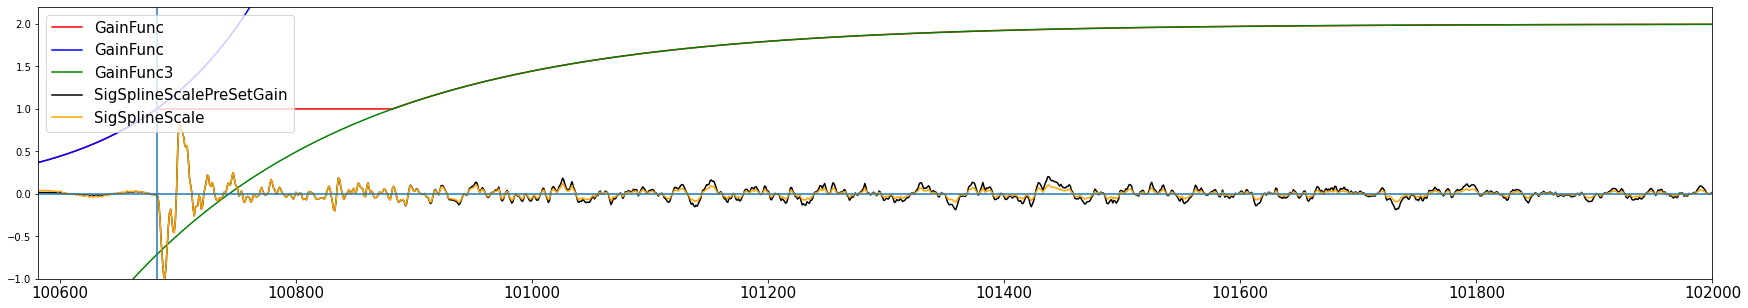

In [ ]:
#    The following Gain Function are not a neccesity
#    They are here so a signal with gain applied can be viewed, investgated if so desired
#     NB there is a probably a better gain function below

def PreSetGainFunc(Onset, SigSplineScale):
  print ('>>>>>>>>>>Onset = ',    Onset)
  GainFunc = []
  GainFunc = (SigSplineScale)*0.00
  #GainFunc = np.zeros(shape=(len(SigSplineScale)))

  OnsetSignalLength = 200
  OnsetplusT = Onset + OnsetSignalLength
  print ("Onset  = "  , Onset)
  print ("OnsetplusT  = "  , OnsetplusT)

  Position  = np.arange(0, len(splinelist[1]), 1)

  Position = Position - Onset
  GainFunc1 = np.power(1.01, Position)
  GainFunc3 = (1-(np.exp((-Position+OnsetSignalLength)/200))) +1

  GainFunc[:Onset] = GainFunc1[:Onset]
  GainFunc[Onset:OnsetplusT] = 1.0
  GainFunc[OnsetplusT:] = GainFunc3[OnsetplusT:]

  SigSplineScalePreSetGain = SigSplineScale * GainFunc   # This may need to be scaled back given that by applying a gain the max value could be greater than 1

  plt.figure(figsize=(30,5))
  plt.ylim([-1, 2.2])
  plt.xlim([Onset-100, len(SigSplineScale)])
  plt.plot(GainFunc, label='GainFunc', color= 'red')
  plt.plot(GainFunc1, label='GainFunc', color= 'blue')
  plt.plot(GainFunc3, label='GainFunc3', color= 'green')
  plt.plot(SigSplineScalePreSetGain, label='SigSplineScalePreSetGain', color= 'black')
  plt.plot(SigSplineScale, label='SigSplineScale', color= 'orange')
  plt.xticks(fontsize = 15)
  #plt.yticks(np.arange(-50, 120, 50))
  plt.rc('xtick',labelsize=20)
  plt.rc('ytick',labelsize=15)
  plt.axhline(y=0)
  plt.axvline(x=Onset)
  plt.legend(fontsize=15)
  plt.show()

  return SigSplineScalePreSetGain

SigSplineScalePreSetGain = PreSetGainFunc(Onset, SigSplineScale)


In [ ]:
#       Having determined the Onset index of the Main signal event (above)
#         This  piece of code looks at the potential subsequent event starts post-Onset
#         It acheives this by looking over a range determined by the F1cfMaxInx and searching forwards to the end of the signal
#         for upto five (5) samples for where the F4cfgrad_gtmean[x] > F4cfgradmeanx2, F4cfgrad_gtmean[x-2]==0 and F4cf[x-1]==0:
#         It writes these to a file, removes all duplicates and then outputs the index values
#         The process/calculation is very similar to that used to find the Onset sample
#
#         Here the search point (index) begins at the Onset sample. It uses the F4cf and F4cfgrad to calculate the Indices of the potential F4cf events
#         The output files are referred to as F4xxx because F4 is used and F4 events are sought  ...again I hope that is as clear as...
#print("F4cfgradmean x 2 is ", F4cfgradmeanx2)

def F4cfOnsets(F1cf, F4cfgradmeanx2, F4cfgrad_gtmean, F4cf, F1cfMaxIndxnp):
  F4cfgradOnsetVal = np.empty((0,0))   # these will be the values
  F4cfgradOnsetIdx = np.empty((0,0))   # these will be the indexes

  for x in range(F1cfMaxIndxnp, len(F1cf),1):
    if F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cf[x-1]==0:   # and F4cfgrad_gtmean[x-1]==0
      F4cfgradOnsetVal = np.append(F4cfgradOnsetVal,  (F4cfgrad_gtmean[x-1]) )
      F4cfgradOnsetIdx = np.append(F4cfgradOnsetIdx,  (x-1))
    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cfgrad_gtmean[x-2]==0 and F4cf[x-2]==0:
      F4cfgradOnsetVal = np.append(F4cfgradOnsetVal,  (F4cfgrad_gtmean[x-2]) )
      F4cfgradOnsetIdx = np.append(F4cfgradOnsetIdx,  (x-2))
    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cfgrad_gtmean[x-3]==0 and F4cf[x-3]==0:
      F4cfgradOnsetVal = np.append(F4cfgradOnsetVal,  (F4cfgrad_gtmean[x-3]) )
      F4cfgradOnsetIdx = np.append(F4cfgradOnsetIdx,  (x-3))
    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cfgrad_gtmean[x-4]==0 and F4cf[x-4]==0:
      F4cfgradOnsetVal = np.append(F4cfgradOnsetVal,  (F4cfgrad_gtmean[x-4]) )
      F4cfgradOnsetIdx = np.append(F4cfgradOnsetIdx,  (x-4))
    elif F4cfgrad_gtmean[x] > F4cfgradmeanx2 and F4cfgrad_gtmean[x-5]==0 and F4cf[x-5]==0:
      F4cfgradOnsetVal = np.append(F4cfgradOnsetVal,  (F4cfgrad_gtmean[x-5]) )
      F4cfgradOnsetIdx = np.append(F4cfgradOnsetIdx,  (x-5))

  #print ("Onset of signal break is at sample: ", Break)

  F4cfgradDF1 = pd.DataFrame(data=F4cfgradOnsetVal, columns=['value'])
  F4cfgradDF2 = pd.DataFrame(data=F4cfgradOnsetIdx, columns=['F4cf_Onset'])

  F4cfgradDF = pd.concat([F4cfgradDF1, F4cfgradDF2], axis=1)

  F4cfgradDF = F4cfgradDF.drop_duplicates()
  F4cfgradDF = F4cfgradDF.reset_index()

  F4cfgrad_np = F4cfgradDF.to_numpy()
  #F4cfgrad_np2 = int(F4cfgradDF['F4cf_Onset'].to_numpy())

  F4cfgradDF['SigOnset'] = Onset

  F4cfgradDF['F4cfTimeIntval(s)'] = (F4cfgradDF['F4cf_Onset'] - F4cfgradDF['SigOnset']) *deltaTime
  F4cfgradDF = F4cfgradDF.astype( {"F4cf_Onset":int,  "SigOnset":int} )

  F4cf_Onset_list = F4cfgradDF['F4cf_Onset'].tolist()
  F4cf_OnsetDF  = sigDF.iloc[F4cf_Onset_list]

  return F4cfgradDF, F4cf_Onset_list, F4cf_OnsetDF

F4cfgradDF, F4cf_Onset_list, F4cf_OnsetDF = F4cfOnsets(F1cf, F4cfgradmeanx2, F4cfgrad_gtmean, F4cf, F1cfMaxIndxnp)

F4cfgrad_np2 = F4cfgradDF['F4cf_Onset'].to_numpy()


The following cell calculates the XCorrs using the full signal of the two input signals - Not an Impulse from one signal + a full signal

I would probably not use this now since it is relatively slow and would likely have more noise.

I prefer the Impulse Xcorrelation which is lower down this sequence of functions

# **INITIAL Xcorrelations and AutoCorrelations**

In [ ]:
def Xcorrs(splinelist, names, Onset):
  print ('>>>>>>>>>>Onset = ',    Onset)
  ####   IN THIS CELL THE SIGSPLINESCALED DATA (SPLINELIST) LEAVES THE PEAK SIGNAL VALUE AS IT IS - THAT IS IT CAN BE +VE OR -VE
  ####    THIS ROUTINE CREATES A SINGLE (SUMMMED) XCORR FOR A TRACES IN splinelist[i]
  ####
  ####    NB  This code Xcorrelates the whole of the signal A versus signal B
  ####    It does not use the impulse ( i.e first 2 -3sec) of signal B  versus signal A
  ####   The impulse Xcorr code runs later and requires all onsets to be known
  splinelistmaxpos = []
  XcorrSet = []
  XcorrShift = []
  XcorrShiftSet = []
  XcorrShiftAdded =[]
  XcorrShiftAddedabs =[]
  XcorrSumAB = []
  XcorrSumBA = []
  XcorNames = []
  Xcorr_maxSet = []
  max = []
  min = []
  print ("names = ",  names)
  names_sub = np.array([x.split('.')[1] for x in names])
  print ("names_sub = ",  names_sub)
  """
  for i in range (0, len(names)):
    if abs(amax(splinelist[i])) > abs(amin(splinelist[i])):
      splinelistmaxpos = np.append(splinelistmaxpos, int(argmax(splinelist[i])))
    else:
      splinelistmaxpos = np.append(splinelistmaxpos, int(argmin(splinelist[i])))
    #print ('splinelistmaxpos=', splinelistmaxpos)
  print ('splinelistmaxpos=', splinelistmaxpos)
  """

  a = splinelist[i]
  a_name = names[i]

  print("a_name = ", a_name)
  XcorrShiftAdded = np.zeros(shape=(len(a)))
  XcorrShiftAddedabs = np.zeros(shape=(len(a)))
  max.append(amax(splinelist[i]))
  min.append(amin(splinelist[i]))
  #XcorrShiftAddedSet = np.zeros(shape=(len(a), 2))  #shape = (len(a), len(names))
  for k in range (0, len(names)):
    b = splinelist[k]
    b_name = names[k]
    print("b_name = ", b_name)
    if a_name == b_name:
      continue
    else:
      Xcorr = np.correlate(a, b, mode='full')
      #print(np.amax(Xcorr), np.amin(Xcorr))
      if abs(amax(Xcorr)) > abs(amin(Xcorr)):
        Xcorr_max = argmax(Xcorr)
      else:
        Xcorr_max = argmin(Xcorr)
      #Xcorr_maxSet = np.append(Xcorr_maxSet, Xcorr_max)
      filename = a_name
      filename = a_name  + '_Xcor_' + b_name
      XcorNames.append(filename)
      #print('XcorNames', XcorNames)
      #Shift = int(Xcorr_max - splinelistmaxpos[i])
      Shift = int(Xcorr_max - Onset)
      XcorrShift = np.roll(Xcorr, -Shift)
      XcorrShift [len(b) + len(a) + 1 - Shift:] = 0
      XcorrShiftedit = XcorrShift[0 : (len(XcorrShift)-len(b)+1)]
      XcorrShifteditabs   = abs(XcorrShiftedit)
      #print ("length of XcorrShiftedit", len(XcorrShiftedit))
      #XcorrShiftSet = np.hstack((XcorrShiftSet, XcorrShiftedit))
      XcorrShiftAdded = XcorrShiftAdded + XcorrShiftedit
      XcorrShiftAddedabs = XcorrShiftAddedabs + XcorrShifteditabs
      #XcorrShiftAddedmax = amax(XcorrShiftAdded)
      #print ('XcorrShiftAdded='  , XcorrShiftAdded, "XcorrShiftAddedmax = ", XcorrShiftAddedmax )
      """
      plt.figure(figsize=(30,2))
      plt.ylim([-10, 10])
      plt.xlim([98500, len(XcorrShiftAdded)])
      #plt.xlim([98500, 99000])
      plt.plot(XcorrShiftedit, label='XcorrShiftedit[i]', color= 'blue')
      plt.plot(XcorrShifteditabs, label='XcorrShifteditabs[i]', color= 'green')
      #plt.yticks(np.arange(-50, 120, 50))
      plt.xticks(fontsize = 15)
      plt.rc('xtick',labelsize=20)
      plt.rc('ytick',labelsize=15)
      plt.axhline(y=0)
      plt.axvline(x=Onset)
      plt.legend(fontsize=15)
      plt.show()
      """

      if len(XcorrSet) == 0:
        XcorrSet = Xcorr
        #print ('XcorrSet nbytes = ', XcorrSet.nbytes)
      else:
        XcorrSet = np.vstack((XcorrSet, Xcorr))  # why didn't np.append((XcorrSet, Xcorr)) not work ??
        #print ('XcorrSet nbytes = ', XcorrSet.nbytes)

    print ('FINAL XcorrShiftAdded='  , XcorrShiftAdded, 'FINAL XcorrShiftAddedtype='  , type(XcorrShiftAdded), 'FINAL XcorrShiftAdded_dtype='  , XcorrShiftAdded.dtype)  #,   "FinalXcorrShiftAddedmax = ", XcorrShiftAddedmax )

    # XcorrShiftAddedSet.append(XcorrShiftAdded)  THIS LINE IS ONLY REQUIRED IF WE PUT ALL THE XcorrShiftAdded RESULTS INTO A 2D ARRAY
    #print ('XcorrShiftAddedSet='  , XcorrShiftAddedSet)

  return XcorrShiftAdded, XcorrShiftAddedabs

XcorrShiftAdded, XcorrShiftAddedabs =  Xcorrs(splinelist, names, Onset)

"""
plt.figure(figsize=(30,2))
#plt.ylim([-20, 40])
plt.ylim([-1, 1])
plt.xlim([98500, len(XcorrShiftAdded)])
#plt.xlim([98500, 99000])
#plt.plot(XcorrShiftAdded, label='XcorrShiftAdded[1]', color= 'red')
plt.plot(splinelist[i], label='splinelist[1]', color= 'red')
plt.xticks(fontsize = 15)
#plt.yticks(np.arange(-50, 120, 50))
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=15)
plt.axhline(y=0)
plt.axvline(x=Onset)
plt.legend(fontsize=15)
plt.show()

plt.figure(figsize=(30,2))
plt.ylim([-20, 40])
plt.xlim([98500, len(XcorrShiftAdded)])
#plt.xlim([98500, 99000])
plt.plot(XcorrShiftAdded, label='XcorrShiftAdded[1]', color= 'blue')
plt.plot(XcorrShiftAddedabs, label='XcorrShiftAddedabs', color= 'green')
#plt.yticks(np.arange(-50, 120, 50))
plt.xticks(fontsize = 15)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=15)
plt.axhline(y=0)
plt.axvline(x=Onset)
plt.legend(fontsize=15)
plt.show()
"""


>>>>>>>>>>Onset =  100682
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_II.ARU.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
FINAL XcorrShiftAdded= [-0.06927666 -0.06811647 -0.06954724 ...  0.32497416  0.38752998
  0.4547402 ] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_II.AAK.00.BHZ
FINAL XcorrShiftAdded= [-0.03372765 -0.04066513 -0.05200732 ...  1.63928005  1.72578694
  1.81431191] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.XAN.00.BHZ
FINAL XcorrShiftAdded= [ 0.00416763 -0.0055495  -0.0115445  ...  1.83205694  1.9588394
  2.07963243] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.WMQ.00.BHZ
F

"\nplt.figure(figsize=(30,2))\n#plt.ylim([-20, 40])\nplt.ylim([-1, 1])\nplt.xlim([98500, len(XcorrShiftAdded)])\n#plt.xlim([98500, 99000])\n#plt.plot(XcorrShiftAdded, label='XcorrShiftAdded[1]', color= 'red')\nplt.plot(splinelist[i], label='splinelist[1]', color= 'red')\nplt.xticks(fontsize = 15)\n#plt.yticks(np.arange(-50, 120, 50))\nplt.rc('xtick',labelsize=20)\nplt.rc('ytick',labelsize=15)\nplt.axhline(y=0)\nplt.axvline(x=Onset)\nplt.legend(fontsize=15) \nplt.show()\n\nplt.figure(figsize=(30,2))\nplt.ylim([-20, 40])\nplt.xlim([98500, len(XcorrShiftAdded)])\n#plt.xlim([98500, 99000])\nplt.plot(XcorrShiftAdded, label='XcorrShiftAdded[1]', color= 'blue')\nplt.plot(XcorrShiftAddedabs, label='XcorrShiftAddedabs', color= 'green')\n#plt.yticks(np.arange(-50, 120, 50))\nplt.xticks(fontsize = 15)\nplt.rc('xtick',labelsize=20)\nplt.rc('ytick',labelsize=15)\nplt.axhline(y=0)\nplt.axvline(x=Onset)\nplt.legend(fontsize=15) \nplt.show()\n"

In [ ]:
print ("names file includes " , names)

names file includes  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']


In [ ]:
XcorrShiftAddedabs
print (len(XcorrShiftAddedabs))

102000


The following cell calculates the ACorrs using the full signal of the input trace (twice) - and Not the Impulse signal + full signal

I would probably not use this now since it is relatively slow and would likely have more noise.

I prefer the Impulse Acorrelation which is the next code cell down

In [ ]:
def AXcorrs(splinelist, names, Onset):
  print ('>>>>>>>>>>Onset = ',    Onset)
  ####   IN THIS CELL THE SIGSPLINESCALED DATA (SPLINELIST) LEAVES THE PEAK SIGNAL VALUE AS IT IS - THAT IS IT CAN BE +VE OR -VE
  ####    THIS ROUTINE HOEFULLY CREATES A SINGLE (SUMMMED) AXCORR FOR A TRACES IN splinelist[i]
  ####
  ####
  ####    NB  This code Acorrelates the whole of the signal A versus signal A
  ####    It does not use the impulse ( i.e first 2 -3sec) of signal A  versus signal A
  ####   The impulse Xcorr code runs later and requires all onsets to be known
  ####
  ####   NB    I would probably NOT use this function now
  splinelistmaxpos = []
  AXcorrSet = []
  AXcorrShift = []
  AXcorrShiftSet = []
  AXcorrShiftAdded =[]
  AXcorrShiftAddedabs =[]
  AXcorrSumAB = []
  AXcorrSumBA = []
  AXcorNames = []
  AXcorr_maxSet = []
  max = []
  min = []

  print ("names = ",  names)
  names_sub = np.array([x.split('.')[1] for x in names])
  print ("names_sub = ",  names_sub)

  a = splinelist[i]
  a_name = names[i]
  print("a_name = ", a_name)
  AXcorrShiftAdded = np.zeros(shape=(len(a)))
  AXcorrShiftAddedabs = np.zeros(shape=(len(a)))
  max.append(amax(splinelist[i]))
  min.append(amin(splinelist[i]))
  #AXcorrShiftAddedSet = np.zeros(shape=(len(a), 2))  #shape = (len(a), len(names))
  for k in range (0, len(names)):
    b = splinelist[k]
    b_name = names[k]
    print("b_name = ", b_name)

    AXcorr = np.correlate(a, b, mode='full')
    #print(np.amax(AXcorr), np.amin(AXcorr))
    if abs(amax(AXcorr)) > abs(amin(AXcorr)):
      AXcorr_max = argmax(AXcorr)
    else:
      AXcorr_max = argmin(AXcorr)
    #AXcorr_maxSet = np.append(AXcorr_maxSet, AXcorr_max)
    filename = a_name
    filename = a_name  + '_AXcor_' + b_name
    AXcorNames.append(filename)
    #print('AXcorNames', AXcorNames)
    Shift = int(AXcorr_max - Onset)
    AXcorrShift = np.roll(AXcorr, -Shift)
    AXcorrShift [len(b) + len(a) + 1 - Shift:] = 0
    AXcorrShiftedit = AXcorrShift[0 : (len(AXcorrShift)-len(b)+1)]
    AXcorrShifteditabs   = abs(AXcorrShiftedit)
    #print ("length of AXcorrShiftedit", len(AXcorrShiftedit))
    #AXcorrShiftSet = np.hstack((AXcorrShiftSet, AXcorrShiftedit))
    AXcorrShiftAdded = AXcorrShiftAdded + AXcorrShiftedit
    AXcorrShiftAddedabs = AXcorrShiftAddedabs + AXcorrShifteditabs
    #AXcorrShiftAddedmax = amax(AXcorrShiftAdded)
    #print ('AXcorrShiftAdded='  , AXcorrShiftAdded, "AXcorrShiftAddedmax = ", AXcorrShiftAddedmax )

    """
    plt.figure(figsize=(30,1))
    plt.ylim([-10, 10])
    plt.xlim([98500, len(AXcorrShiftAdded)])
    #plt.xlim([98500, 99000])
    plt.plot(AXcorrShiftedit, label='AXcorrShiftedit[i]', color= 'blue')
    plt.plot(AXcorrShifteditabs, label='AXcorrShifteditabs[i]', color= 'green')
    #plt.yticks(np.arange(-50, 120, 50))
    plt.xticks(fontsize = 15)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=15)
    plt.axhline(y=0)
    plt.axvline(x=Onset)
    plt.legend(fontsize=15)
    plt.show()
    """

    if len(AXcorrSet) == 0:
      AXcorrSet = AXcorr
      #print ('AXcorrSet nbytes = ', AXcorrSet.nbytes)
    else:
      AXcorrSet = np.vstack((AXcorrSet, AXcorr))  # why didn't np.append((AXcorrSet, AXcorr)) not work ??
      #print ('AXcorrSet nbytes = ', AXcorrSet.nbytes)

  print ('FINAL AXcorrShiftAdded='  , AXcorrShiftAdded, 'FINAL AXcorrShiftAddedtype='  , type(AXcorrShiftAdded), 'FINAL AXcorrShiftAdded_dtype='  , AXcorrShiftAdded.dtype)  #,   "FinalAXcorrShiftAddedmax = ", AXcorrShiftAddedmax )

  # AXcorrShiftAddedSet.append(AXcorrShiftAdded)  THIS LINE IS ONLY REQUIRED IF WE PUT ALL THE AXcorrShiftAdded RESULTS INTO A 2D ARRAY
  #print ('AXcorrShiftAddedSet='  , AXcorrShiftAddedSet)

  return AXcorrShiftAdded, AXcorrShiftAddedabs

AXcorrShiftAdded, AXcorrShiftAddedabs =  AXcorrs(splinelist, names, Onset)


>>>>>>>>>>Onset =  100682
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_II.ARU.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.KMI.00.BHZ
b_name =  splineName_II.ARU.00.BHZ
FINAL AXcorrShiftAdded= [0.05176466 0.07245886 0.10131912 ... 2.2169098  2.32709051 2.52399226] FINAL AXcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL AXcorrShiftAdded_dtype= float64


## Following cell is code for ACorr using a 3 second (60 ssample) Impulse from the Onset time from the SigSpline trace - cf with the XCorr using impulses  in a cell further down

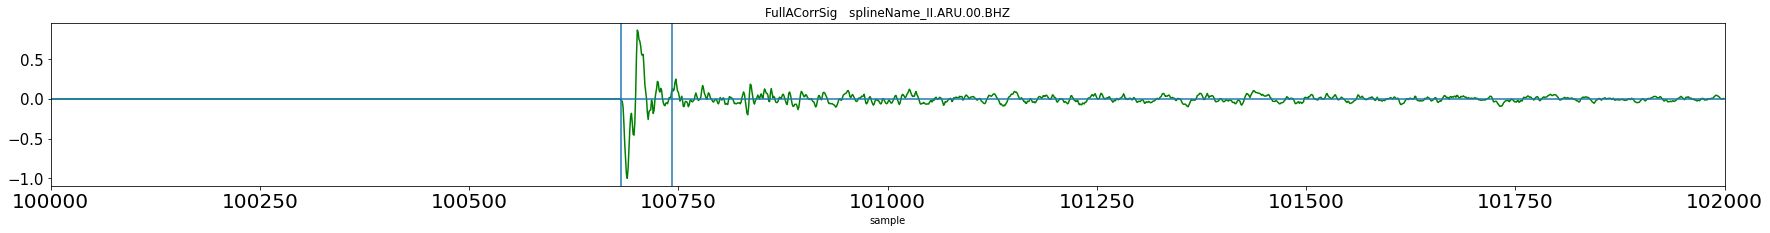

maxvalue post Impulse =  0.946116389416635


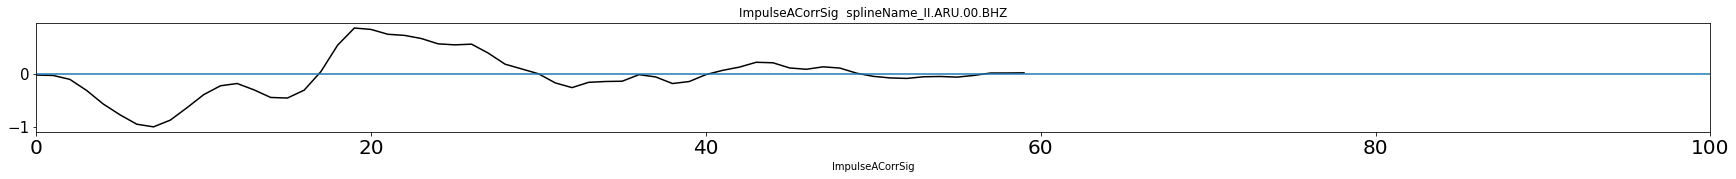

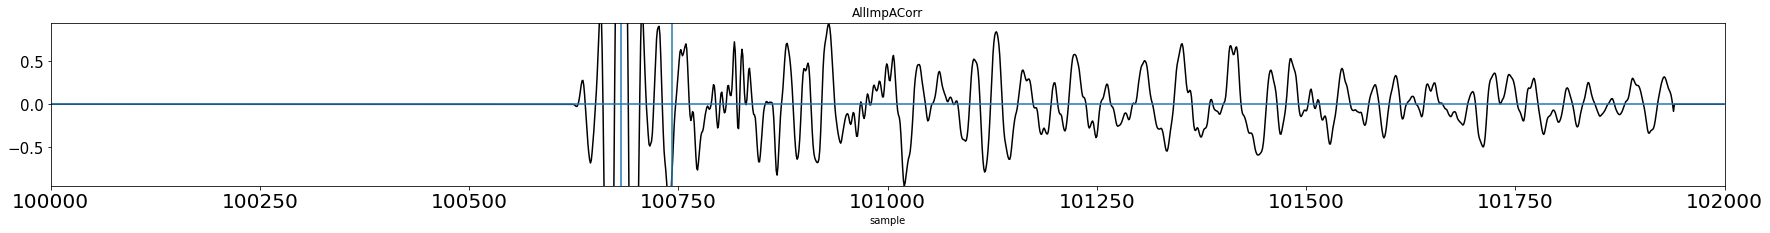

In [ ]:
####
####    NB  This code Acorrelates the impulse ( i.e first 2 -3sec) of signal A  versus signal A
####
####    NB    I now consider this a better, cleaner Autocorrelation routine
def ImpulseACorrs(splinelist, names, Onset):
  ImpACorrSet = []
  AllImpXcorrAddedabs =   []
  ImpACorrNames = []
  AllImpACorr = np.zeros(len(splinelist[i]))

  names_sub = np.array([x.split('.')[1] for x in names])
  a_name = names[i]

  FullACorrSig = splinelist[i]
  FullACorrSig[0 : Onset] = 0
  ImpulseACorrSig = splinelist[i][Onset:Onset+60]

  plt.figure(figsize=(30,3))
  plt.plot(FullACorrSig,  label='FullACorrSig ', color= 'green')
  plt.xlabel('sample')
  #plt.ylim (-1,1)
  plt.xlim(100000,102000)
  plt.axvline(Onset)
  plt.axvline(Onset+60)
  plt.axhline(0)
  plt.title('FullACorrSig   ' +str(a_name))
  plt.show()

  for j in range (0, (len(FullACorrSig)-60) ):
        ImpACorr = np.correlate(FullACorrSig[j:j+60], ImpulseACorrSig, mode='valid')    # was 'valid'  but since looking at whole signal no longer applicable
        AllImpACorr[j] = ImpACorr


  filename = a_name
  filename = a_name  + '_ACorr_'
  ImpACorrNames.append(filename)

  maxx = np.max(abs(AllImpACorr[Onset+60:]))
  print('maxvalue post Impulse = ',maxx )

  plt.figure(figsize=(30,2))
  plt.plot(ImpulseACorrSig,  label='ImpulseACorrSig ', color= 'black')
  plt.xlabel('ImpulseACorrSig')
  #plt.ylim (-1,1)
  plt.xlim(0,100)
  plt.axvline(Onset)
  plt.axvline(Onset+60)
  plt.axhline(0)
  plt.title('ImpulseACorrSig  '  +str(a_name))
  plt.show()

  plt.figure(figsize=(30,3))
  plt.plot(AllImpACorr,  label='AllImpACorr ', color= 'black')
  plt.xlabel('sample')
  plt.ylim (-maxx,maxx)
  plt.xlim(100000,102000)
  plt.axvline(Onset)
  plt.axvline(Onset+60)
  plt.axhline(0)
  plt.title('AllImpACorr')
  plt.show()

  return AllImpACorr

AllImpACorr = ImpulseACorrs(splinelist, names, Onset)

The Following Cell has 4 parts

The ***1st Function*** creates an inverted absolute of the SigSplineScaled trace

The ***2st function*** extracts the trend of the signal by sampling the max / min within evry 20th sample group. The trend is then infilled (Python doesnt like extracting formulae with Nans)


The ***3nd function*** defines a formulae  based on the infilled The formula type is predefined and Python calculates the parameterisaton of the formula (ie A, B, C).
The formulae type employed here is ((a*np.exp(-b*(x - Onset))) + c)



$$ Gain = Aexp^{-B(x-Onset)} + C $$



The ***4rd function*** creates an array of the Gain  which can then be applied to the signal

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
>>>>>>>>>>Onset =  100682
>>>>>>>>>>Onset =  100682
65


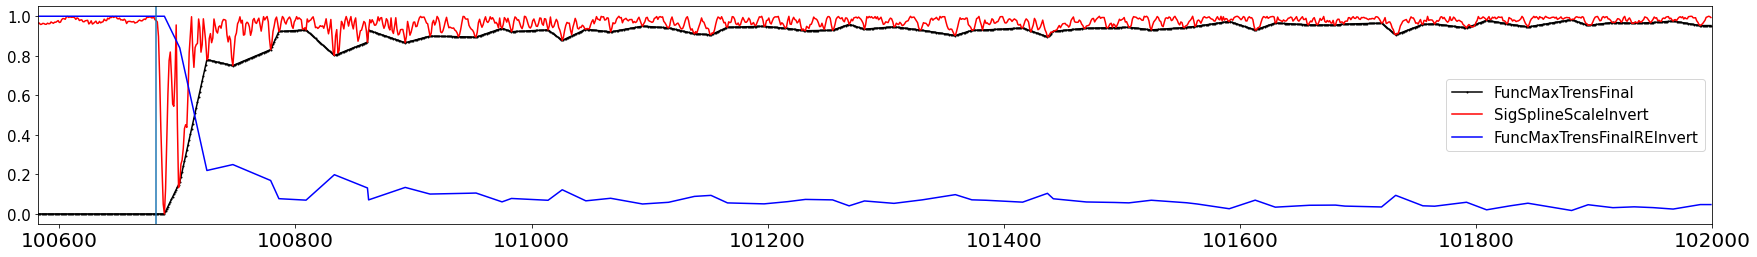

>>>>>>>>>>Onset =  100682
y = (1.11481*e ** (0.02809(x - Onset)) + 0.06348
x_line.shape =  (1317,)
y_line =  [1.17829157 1.1474166  1.11739671 ... 0.06347759 0.06347759 0.06347759]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


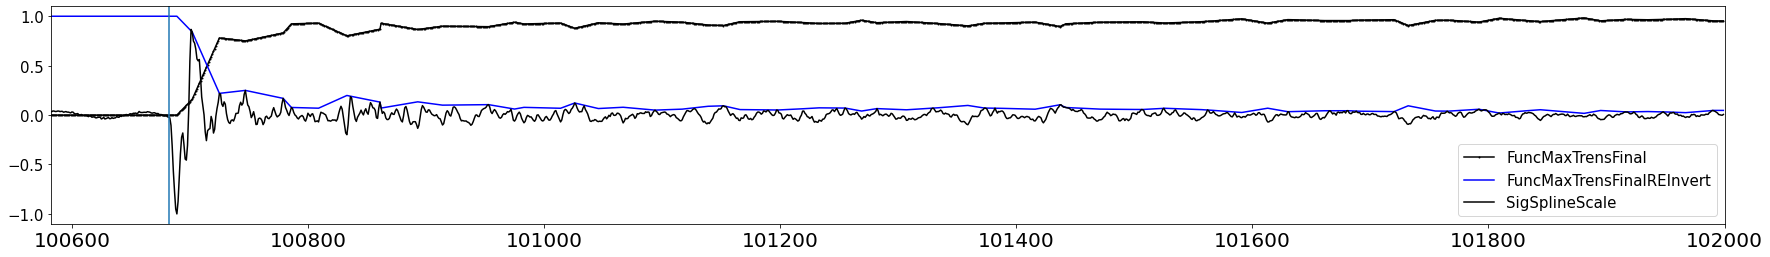

a ==  1.1148139849837
b ==  0.028085926300427545
c ==  0.06347758901410853
GainFunction1max =  1.1782915739978086 GainFunction1min = 0.06347758901410863
GainFunction1max =  1.0 GainFunction1min = 0.05387256466473441


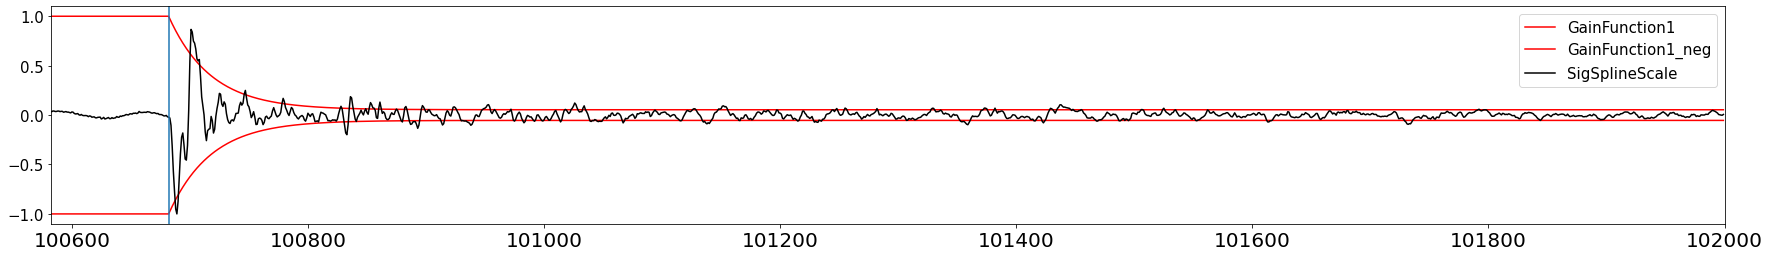

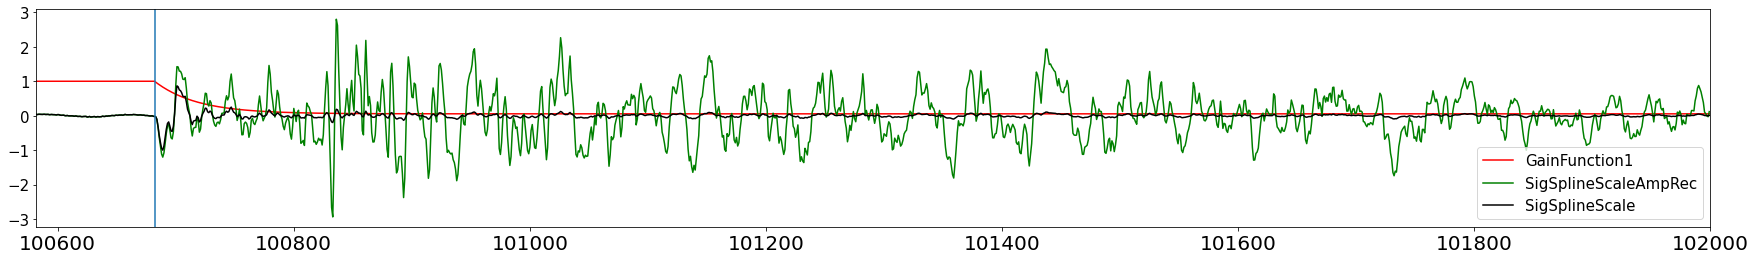

a ==  1.1148139849837
b ==  0.028085926300427545
c ==  0.06347758901410853


'\n# plot input vs output\nplt_1 = plt.figure(figsize=(30, 4))\nplt.xlim(100000, 102000) \n#pyplot.scatter(x, y)\n##x_line = arange(min(x), max(x), 1)\n##print("x_line.shape = ", x_line.shape)\n# calculate the output for the range\n##y_line = GainFunction(x_line, a, b, c)\n##print(\'y_line = \',   y_line)\n##pyplot.plot(x_line, y_line, \'-\', color=\'red\')\nplt.plot(FuncMaxTrensFinalREInvert, label=\'FuncMaxTrensFinalREInvert\', color= \'blue\', markersize=2)\nplt.plot(SigSplineScale, label=\'SigSplineScale\', color= \'black\', markersize=2)\nplt.plot(GainFunction1, label=\'GainFunction1\', color= \'green\', markersize=2)\nplt.plot(GainFunction2, label=\'GainFunction2\', color= \'orange\', markersize=2)\nplt.plot(SigSplineScaleAmpRec, label=\'SigSplineScaleAmpRec\', color= \'red\', markersize=2)\nplt.plot(SigSplineScaleAmpRec2, label=\'SigSplineScaleAmpRec2\', color= \'magenta\', markersize=2)\nplt.axvline(x=Onset)\n#plt.legend(fontsize=15) \npyplot.show()\n'

In [ ]:
def SplineScale_Invert(npts, SigSplineScale, Onset):
  print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
  print ('>>>>>>>>>>Onset = ',    Onset)
  SigSplineScaleInvert = np.zeros(npts)
  SigSplineScaleAbs = abs(SigSplineScale)
  SigSplineScaleInvert = (1-SigSplineScaleAbs)

  return SigSplineScaleInvert

SigSplineScaleInvert = SplineScale_Invert(npts, SigSplineScale, Onset)

def SignalTrendData(SigSplineScaleInvert, Onset):
  print ('>>>>>>>>>>Onset = ',    Onset)
  FuncMaxTrensFinal = np.zeros(len(SigSplineScaleInvert))
  FuncMaxTrens = np.zeros(len(SigSplineScaleInvert))
  FuncMaxTrens[:] = -1
  xp = np.empty((0,0))
  fp = np.empty((0,0))

  nsamp = len(SigSplineScaleInvert) - Onset
  kk = np.floor_divide(nsamp, 20)
  print (kk)

  for x in range(Onset, len(SigSplineScaleInvert),20):
    zv = min((SigSplineScaleInvert)[x:x+20])
    zk = x + np.argmin((SigSplineScaleInvert)[x:x+20])
    FuncMaxTrens[zk] = zv
    xp   =  np.append(xp, zv)
    fp   =  np.append(fp, zk)

  ListOfMinima=np.array(list(zip(fp, xp)))   #THIS LINE creates a 2D array col[0] = fp the sample number and col[1] = xp the values
  FuncMaxTrens = np.where(FuncMaxTrens > -0.5, FuncMaxTrens, nan)

  r = Sample[Onset:]
  c = np.setdiff1d(r, fp)  # THIS LINE GIVES THE VALUES IN `r` THAT ARE NOT IN `fp`.

  FuncMaxTrensIntp = np.interp(c, fp, xp)           # THESE ARE THE INTERPOLATED VALUES BUT DONT INCLUDE THE EXTRACTED VALUES
  FuncMaxTrensIntp = np.asarray(FuncMaxTrensIntp)   # converts FuncMaxTrensIntp into an array

  ListOfMinimaTrend=np.array(list(zip(c, FuncMaxTrensIntp)))  # THIS LINE creates a 2D array col[0] = sample number and col[1] = values
  #print("ListOfMinimaTrend =   ", ListOfMinimaTrend[:20])

  CombinedList =  np.vstack((ListOfMinima,ListOfMinimaTrend))   # This line stacks together the extracted values (fp = ListOfMinima) and the interpolated values (c = ListOfMinimaTrend)
  CombinedListSorted = CombinedList[np.argsort(CombinedList[:, 0])]  # This line sorts the array based on sample number

  TrendValues = CombinedListSorted[:, 1]
  #print("head of TrendValues =   ", TrendValues[:30])

  FuncMaxTrensFinal[Onset:] = TrendValues[:]
  FuncMaxTrensFinalREInvert = 1 - FuncMaxTrensFinal

  plt.figure(figsize=(30,4))
  plt.xlim([Onset-100, len(FuncMaxTrens)])
  #plt.plot(CombinedListSorted[:,0], CombinedListSorted[:,1], 'o', alpha=0.5)
  plt.plot(FuncMaxTrensFinal, marker='o', alpha=1.0, color='black', markersize=1, label='FuncMaxTrensFinal')
  plt.plot(SigSplineScaleInvert, label='SigSplineScaleInvert', color= 'red', markersize=2)
  plt.plot(FuncMaxTrensFinalREInvert, label='FuncMaxTrensFinalREInvert', color= 'blue', markersize=2)
  plt.axvline(x=Onset)
  plt.legend(fontsize=15)
  plt.show()

  return FuncMaxTrensFinal, FuncMaxTrensFinalREInvert

FuncMaxTrensFinal, FuncMaxTrensFinalREInvert = SignalTrendData(SigSplineScaleInvert, Onset)

#    The following Gain Function is not a neccesity
#    They are here so a signal with gain applied can be viewed, investgated if so desired
#    This Gain Function is likely better than the one above

def GainFunction(Sample, FuncMaxTrensFinalREInvert, Onset, FuncMaxTrensFinal, SigSplineScale):
  print ('>>>>>>>>>>Onset = ',    Onset)
  def GainEquation(x, a, b, c):
    return ((a*np.exp(-b*(x - Onset))) + c)

  x, y = Sample[Onset:], FuncMaxTrensFinalREInvert[Onset:]

  popt, _ = curve_fit(GainEquation, x, y, maxfev=9000)
  a, b, c = popt
  print ('y = (%.5f*e ** (%.5f(x - Onset)) + %.5f' % (a, b, c))

  ## plot input vs output
  #plt_1 = plt.figure(figsize=(30, 4))
  #plt.xlim([Onset-100, len(FuncMaxTrensFinalREInvert)])
  ##pyplot.scatter(x, y)
  x_line = arange(min(x), max(x), 1)
  print("x_line.shape = ", x_line.shape)
  ## calculate the output for the range
  y_line = GainEquation(x_line, a, b, c)
  print('y_line = ',   y_line)
  #pyplot.plot(x_line, y_line, '-', color='red')
  plt.figure(figsize=(30,4))
  plt.xlim([Onset-100, len(FuncMaxTrensFinalREInvert)])
  plt.plot(FuncMaxTrensFinal, marker='o', alpha=1.0, color='black', markersize=1, label='FuncMaxTrensFinal')

  plt.plot(FuncMaxTrensFinalREInvert, label='FuncMaxTrensFinalREInvert', color= 'blue', markersize=2)
  plt.plot(SigSplineScale, label='SigSplineScale', color= 'black', markersize=2)
  plt.axvline(x=Onset)
  plt.legend(fontsize=15)
  pyplot.show()

  print ("a == ", a)
  print ("b == ", b)
  print ("c == ", c)

  return a,b,c

a,b,c =   GainFunction(Sample, FuncMaxTrensFinalREInvert, Onset, FuncMaxTrensFinal, SigSplineScale)

def GainFunctionArray(a, b, c, Sample, Onset, SigSplineScale, SigSplineScaleInvert):   # MAYBR USE AGC in title
  GainFunction1 = np.empty(len(SigSplineScaleInvert))
  GainFunction1.fill(1.000)
  for i in range(Onset, len(Sample)):
    GainFunction1 [i] = ((a*np.exp(-b*(Sample[i] - Onset))) + c)

  m = max(GainFunction1)
  m2 = min(GainFunction1)
  print ("GainFunction1max = ", m, "GainFunction1min =", m2)
  GainFunction1 = GainFunction1/m
  GainFunction1[0:Onset] = 1.000
  m = max(GainFunction1)
  m2 = min(GainFunction1)
  print ("GainFunction1max = ", m, "GainFunction1min =", m2)

  GainFunction1_neg = GainFunction1 *(-1.000000)

  SigSplineScaleAmpRec    = SigSplineScale/GainFunction1

  plt.figure(figsize=(30,4))
  plt.xlim([Onset-100, len(SigSplineScaleInvert)])
  plt.plot(GainFunction1, label='GainFunction1', color= 'red', markersize=2)
  plt.plot(GainFunction1_neg, label='GainFunction1_neg', color= 'red', markersize=2)
  plt.plot(SigSplineScale, label='SigSplineScale', color= 'black')
  #plt.plot(SigSplineScaleAmpRec, label='SigSplineScaleAmpRec', color= 'green')
  plt.axvline(x=Onset)
  plt.legend(fontsize=15)
  plt.show()

  plt.figure(figsize=(30,4))
  plt.xlim([Onset-100, len(SigSplineScaleInvert)])
  plt.plot(GainFunction1, label='GainFunction1', color= 'red', markersize=2)
  plt.plot(SigSplineScaleAmpRec, label='SigSplineScaleAmpRec', color= 'green')
  plt.plot(SigSplineScale, label='SigSplineScale', color= 'black')
  plt.axvline(x=Onset)
  plt.legend(fontsize=15)
  plt.show()

  return GainFunction1, SigSplineScaleAmpRec  #, GainFunction2, SigSplineScaleAmpRec2

GainFunction1, SigSplineScaleAmpRec = GainFunctionArray(a, b, c, Sample, Onset, SigSplineScale, SigSplineScaleInvert)

print ("a == ", a)
print ("b == ", b)
print ("c == ", c)
"""
# plot input vs output
plt_1 = plt.figure(figsize=(30, 4))
plt.xlim(100000, 102000)
#pyplot.scatter(x, y)
##x_line = arange(min(x), max(x), 1)
##print("x_line.shape = ", x_line.shape)
# calculate the output for the range
##y_line = GainFunction(x_line, a, b, c)
##print('y_line = ',   y_line)
##pyplot.plot(x_line, y_line, '-', color='red')
plt.plot(FuncMaxTrensFinalREInvert, label='FuncMaxTrensFinalREInvert', color= 'blue', markersize=2)
plt.plot(SigSplineScale, label='SigSplineScale', color= 'black', markersize=2)
plt.plot(GainFunction1, label='GainFunction1', color= 'green', markersize=2)
plt.plot(GainFunction2, label='GainFunction2', color= 'orange', markersize=2)
plt.plot(SigSplineScaleAmpRec, label='SigSplineScaleAmpRec', color= 'red', markersize=2)
plt.plot(SigSplineScaleAmpRec2, label='SigSplineScaleAmpRec2', color= 'magenta', markersize=2)
plt.axvline(x=Onset)
#plt.legend(fontsize=15)
pyplot.show()
"""

# **FIRST Batch Run**


The following code runs a batch of signals But beware

1.  num_attributes needs to be defined and hardwired here
2.  the code does not do the impulse XCorr etc since the functions emplyed have not gathered data

See Second batch run below

appending 0
appending 1
appending 2
appending 3
appending 4
appending 5
Number of signals  = 6

npts =  102000 

IC.HIA.00.BHZ
0

npts =  102000 

II.AAK.00.BHZ
1

npts =  102000 

IC.XAN.00.BHZ
2

npts =  102000 

IC.WMQ.00.BHZ
3

npts =  102000 

IC.KMI.00.BHZ
4

npts =  102000 

II.ARU.00.BHZ
5

 +++++++++++++++++++++++++++++++++++++++++ 
 
 +  All inputSignalLengths are the Same  + 
 
 +++++++++++++++++++++++++++++++++++++++++ 

++++++++++++++++++++++++++++++++++++++++++++++++++
sig       =  [-2961 -2878 -2783 ... -2354 -2203 -2378]
deltaTime =  0.05
a1 (starttime) =  2018-09-01T14:25:45.069536Z
a2 (endtime)   =  2018-09-01T15:50:45.019536Z
npts     =  102000
SampRate =  20.0
station  =  HIA
SigSplineScale shape =  (102000,)

 SigSplineMaxMinIndx = 98709 
 F1cfMaxMinIndx      = 98705 
 The F1cf max value precedes the Min or Max SigSpline value =  0.2 sec
The F1cf max is LESS than 30 secs ahead of the Min or Max SigSpline value  
REVIEW SIGNAL AND POSITION OF MAX F1cf TO MAIN SIGNAL

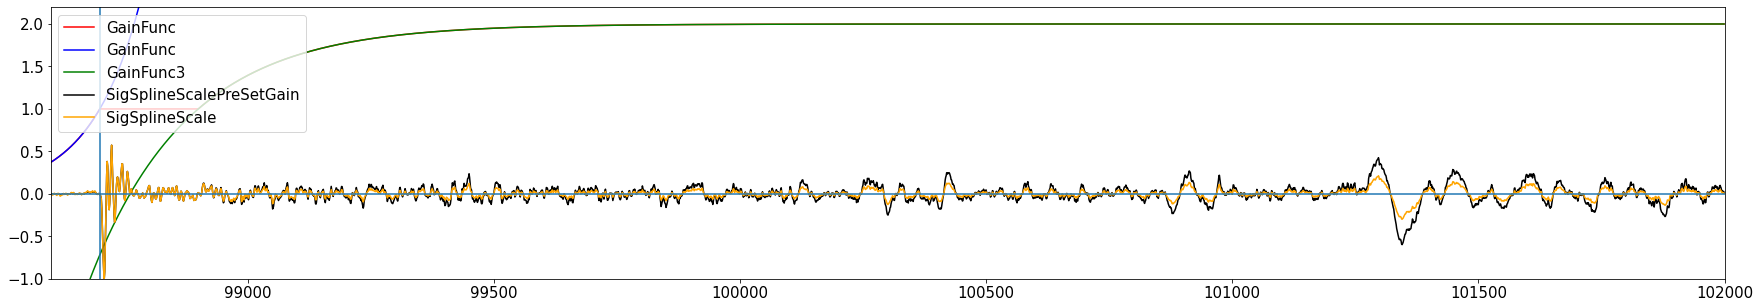

>>>>>>>>>>Onset =  98700
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_II.AAK.00.BHZ
FINAL XcorrShiftAdded= [ 0.          0.          0.         ... -0.02780944 -0.01724734
 -0.00935786] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.XAN.00.BHZ
FINAL XcorrShiftAdded= [ 0.          0.          0.         ... -0.0602915  -0.03868663
 -0.02269673] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.WMQ.00.BHZ
FINAL XcorrShiftAdded= [ 0.          0.          0.         ... -0.32904262 -0.29900262
 -0.26901935] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b

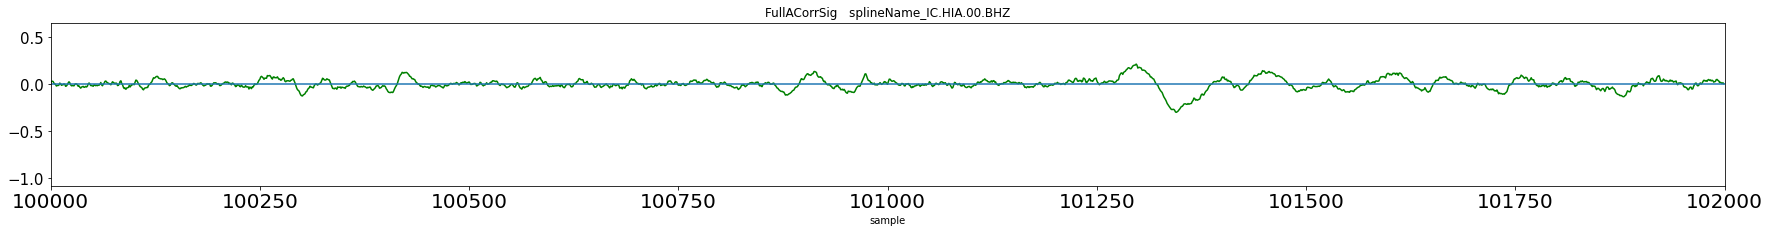

maxvalue post Impulse =  1.6111180037810455


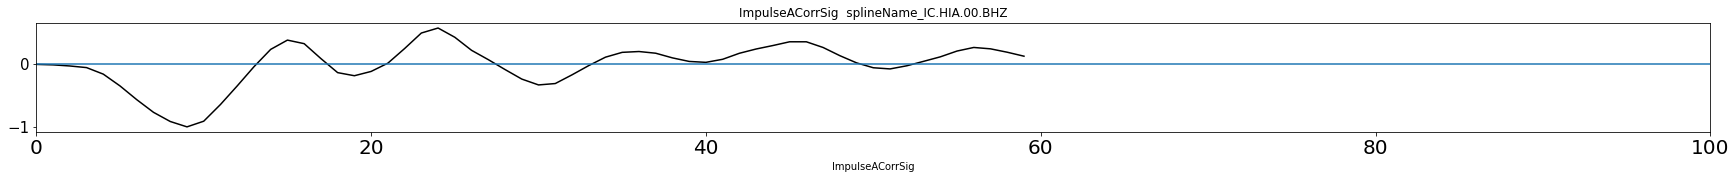

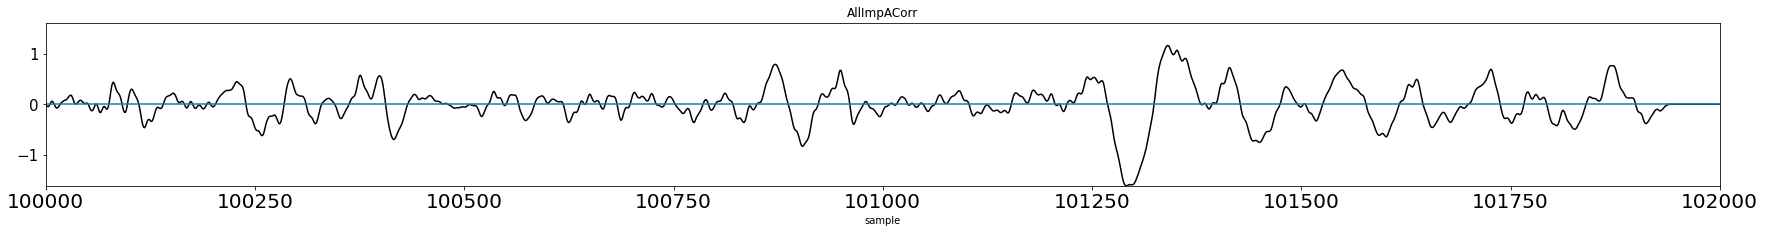

>>>>>>>>>>Onset =  98700
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.KMI.00.BHZ
b_name =  splineName_II.ARU.00.BHZ
FINAL AXcorrShiftAdded= [ 0.          0.          0.         ... -0.34921609 -0.31157041
 -0.27642967] FINAL AXcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL AXcorrShiftAdded_dtype= float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
>>>>>>>>>>Onset =  98700
>>>>>>>>>>Onset =  98700
165


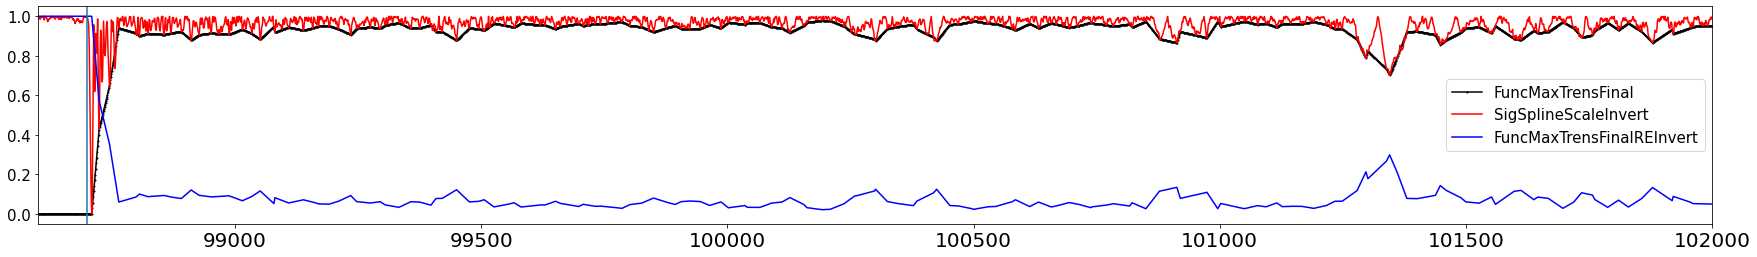

>>>>>>>>>>Onset =  98700
y = (1.14798*e ** (0.03460(x - Onset)) + 0.06688
x_line.shape =  (3299,)
y_line =  [1.21485931 1.17581787 1.13810417 ... 0.06687957 0.06687957 0.06687957]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


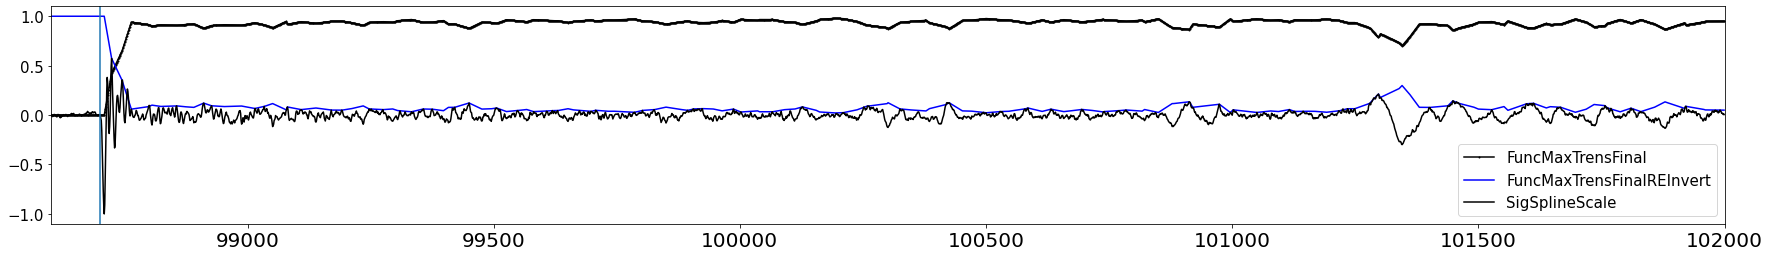

a ==  1.1479797444115287
b ==  0.03460058527408581
c ==  0.06687956894858302
GainFunction1max =  1.2148593133601118 GainFunction1min = 0.06687956894858302
GainFunction1max =  1.0 GainFunction1min = 0.05505128718452554


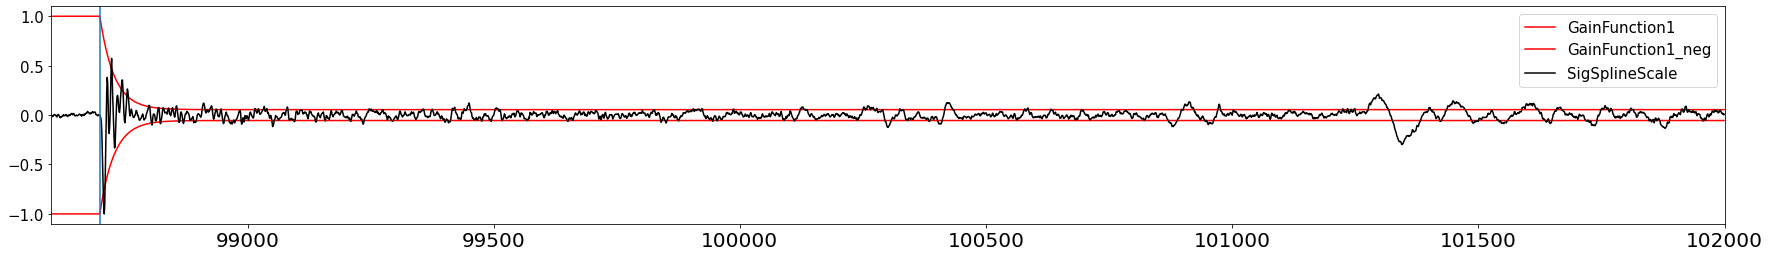

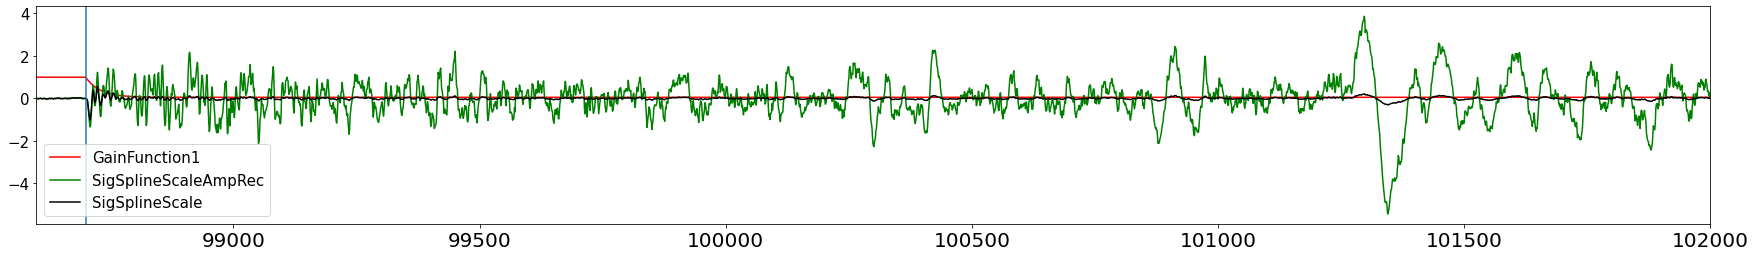

++++++++++++++++++++++++++++++++++++++++++++++++++
sig       =  [3152 3153 3073 ... 2321 2268 2364]
deltaTime =  0.05
a1 (starttime) =  2018-09-01T14:29:14.219538Z
a2 (endtime)   =  2018-09-01T15:54:14.169538Z
npts     =  102000
SampRate =  20.0
station  =  AAK
SigSplineScale shape =  (102000,)

 SigSplineMaxMinIndx = 99005 
 F1cfMaxMinIndx      = 98989 
 The F1cf max value precedes the Min or Max SigSpline value =  0.8 sec
The F1cf max is LESS than 30 secs ahead of the Min or Max SigSpline value  
REVIEW SIGNAL AND POSITION OF MAX F1cf TO MAIN SIGNAL 
F1cfMaxnp = 12.4063938775015
Onset time = 98983
>>>>>>>>>>Onset =  98983
Onset  =  98983
OnsetplusT  =  99183


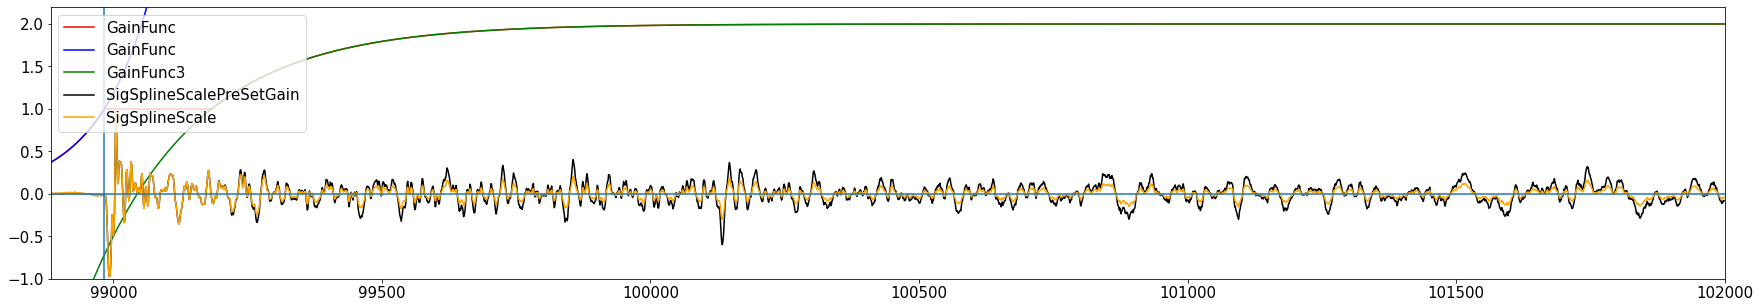

>>>>>>>>>>Onset =  98983
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
FINAL XcorrShiftAdded= [0. 0. 0. ... 0. 0. 0.] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.XAN.00.BHZ
FINAL XcorrShiftAdded= [0.         0.         0.         ... 0.16390512 0.12761592 0.09236627] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.WMQ.00.BHZ
FINAL XcorrShiftAdded= [0.         0.         0.         ... 0.18501723 0.14034762 0.09899325] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.KMI.00.BHZ
FINAL XcorrShiftAdded= [0.         

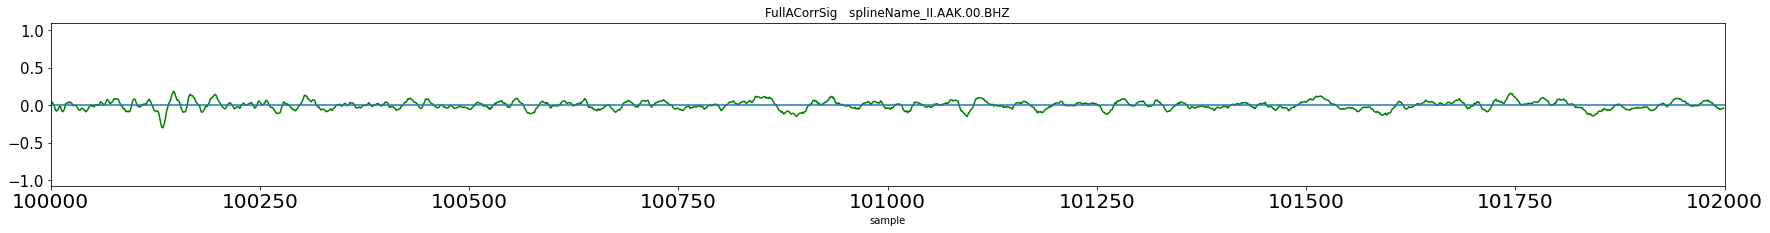

maxvalue post Impulse =  2.729349722494349


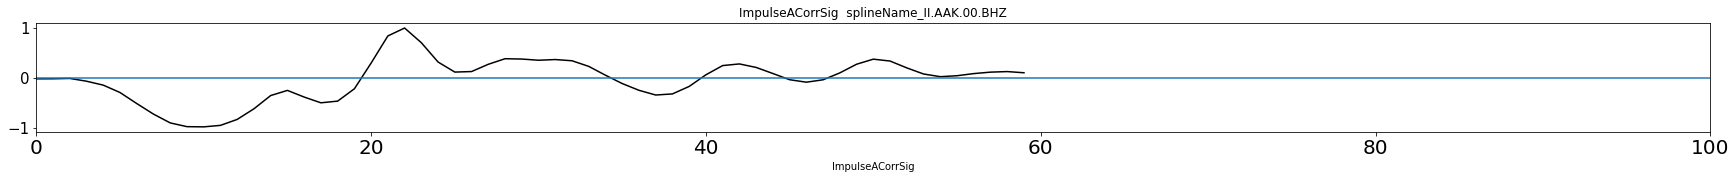

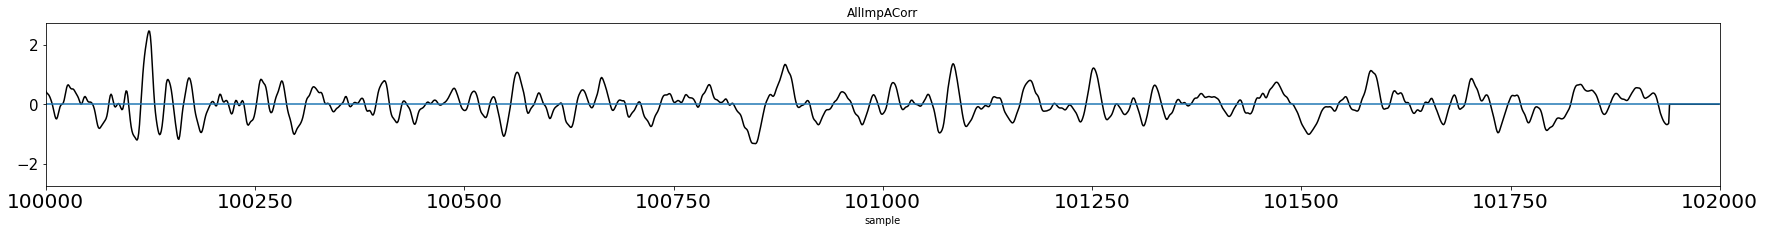

>>>>>>>>>>Onset =  98983
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.KMI.00.BHZ
b_name =  splineName_II.ARU.00.BHZ
FINAL AXcorrShiftAdded= [0.         0.         0.         ... 0.1977297  0.14694129 0.10142427] FINAL AXcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL AXcorrShiftAdded_dtype= float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
>>>>>>>>>>Onset =  98983
>>>>>>>>>>Onset =  98983
150


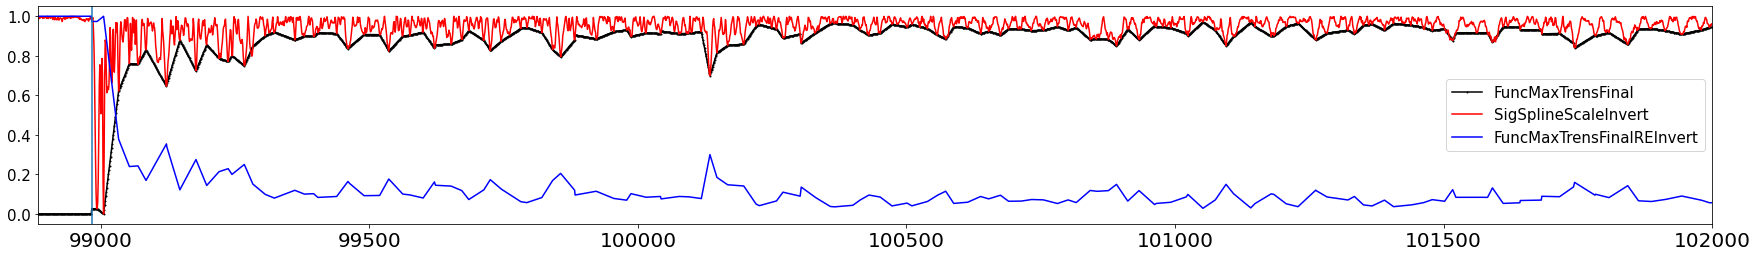

>>>>>>>>>>Onset =  98983
y = (1.02358*e ** (0.01743(x - Onset)) + 0.09310
x_line.shape =  (3016,)
y_line =  [1.11667964 1.09898967 1.08160543 ... 0.09309529 0.09309529 0.09309529]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


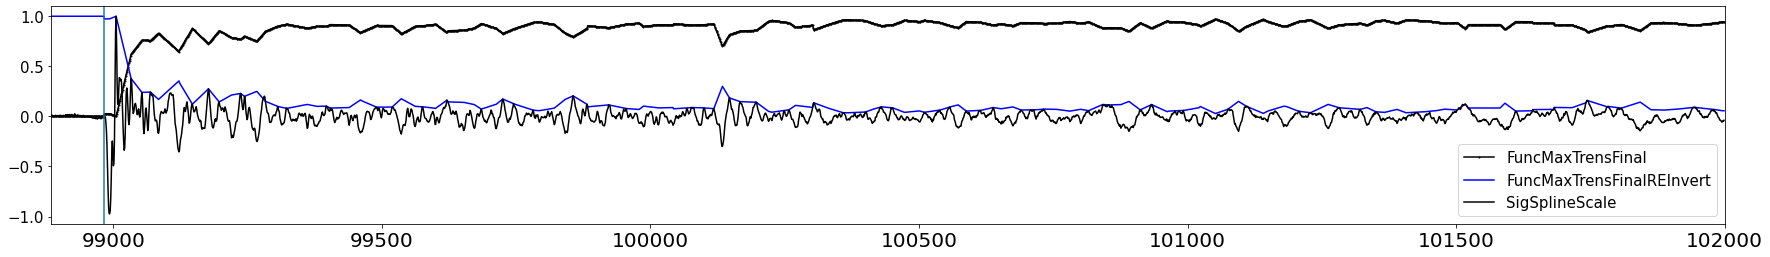

a ==  1.0235843588563476
b ==  0.017433459975303264
c ==  0.09309528545987417
GainFunction1max =  1.1166796443162217 GainFunction1min = 0.09309528545987417
GainFunction1max =  1.0 GainFunction1min = 0.08336794346858481


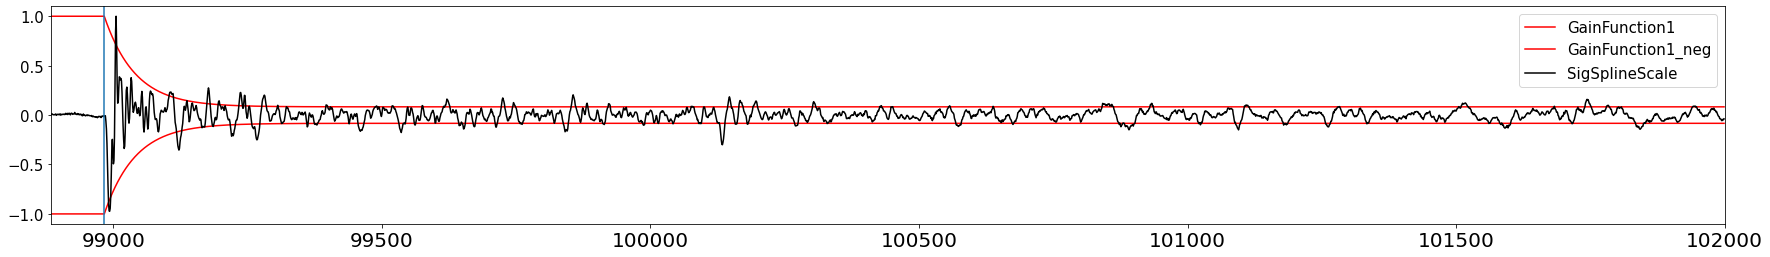

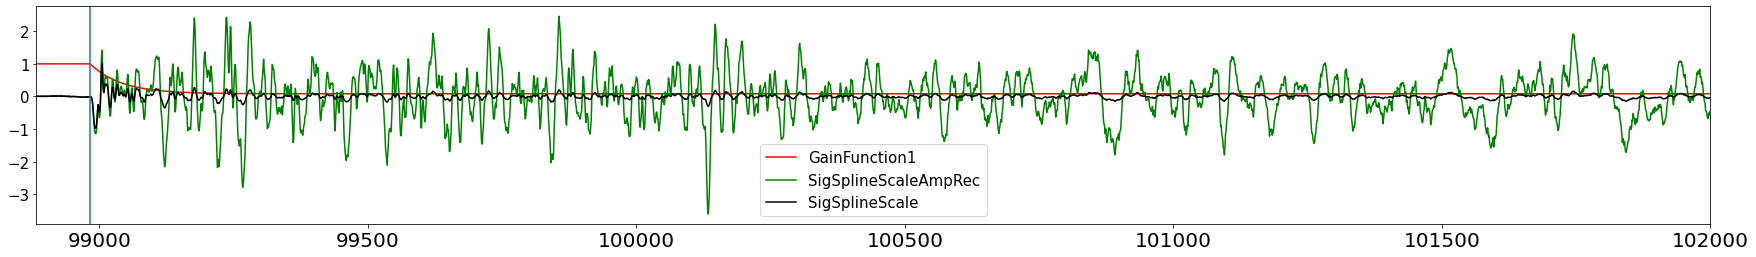

++++++++++++++++++++++++++++++++++++++++++++++++++
sig       =  [-3234 -3328 -3624 ... -4027 -4304 -4463]
deltaTime =  0.05
a1 (starttime) =  2018-09-01T14:27:45.869538Z
a2 (endtime)   =  2018-09-01T15:52:45.819538Z
npts     =  102000
SampRate =  20.0
station  =  XAN
SigSplineScale shape =  (102000,)

 SigSplineMaxMinIndx = 96444 
 F1cfMaxMinIndx      = 96433 
 The F1cf max value precedes the Min or Max SigSpline value =  0.55 sec
The F1cf max is LESS than 30 secs ahead of the Min or Max SigSpline value  
REVIEW SIGNAL AND POSITION OF MAX F1cf TO MAIN SIGNAL 
F1cfMaxnp = 7.500637518454668
Onset time = 96428
>>>>>>>>>>Onset =  96428
Onset  =  96428
OnsetplusT  =  96628


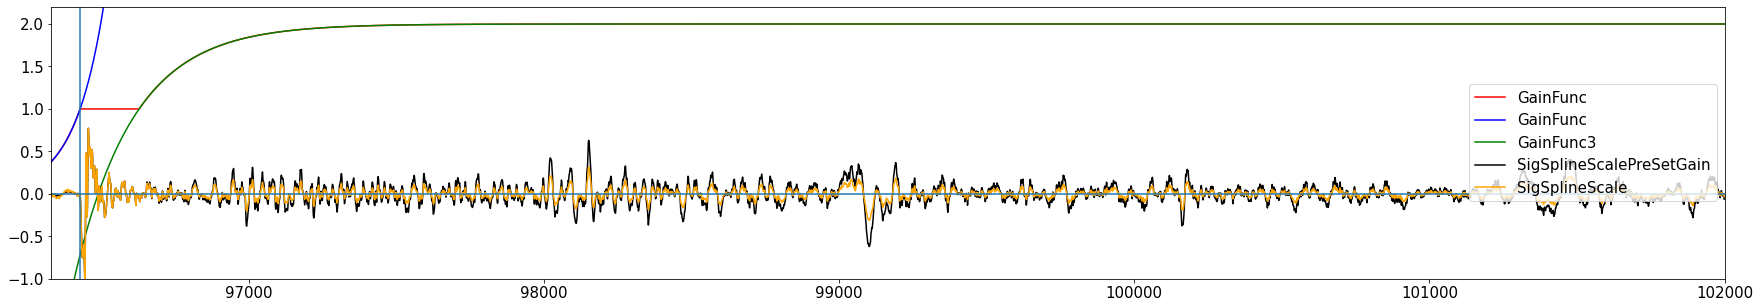

>>>>>>>>>>Onset =  96428
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
FINAL XcorrShiftAdded= [0. 0. 0. ... 0. 0. 0.] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_II.AAK.00.BHZ
FINAL XcorrShiftAdded= [0. 0. 0. ... 0. 0. 0.] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.WMQ.00.BHZ
FINAL XcorrShiftAdded= [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.28845551e-04
 -2.66954586e-05  0.00000000e+00] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.KMI.00.BHZ
FINAL XcorrShiftAdded= [0.         0.         0.    

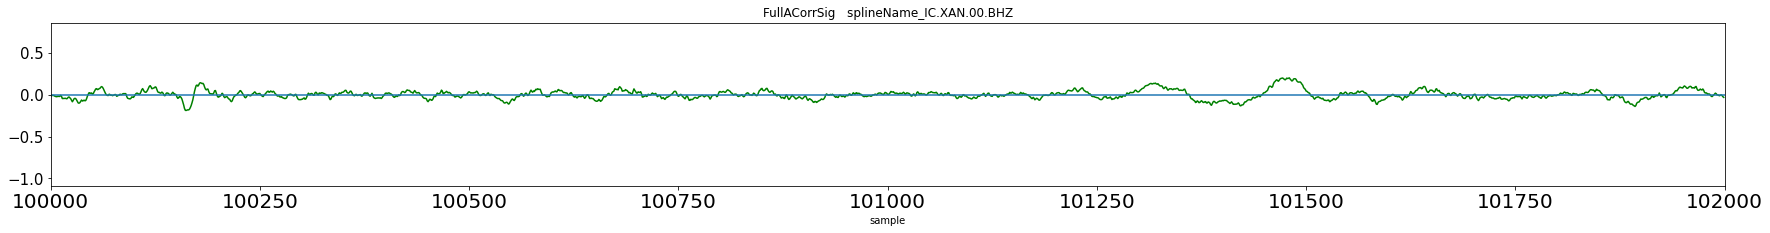

maxvalue post Impulse =  3.8871906360105983


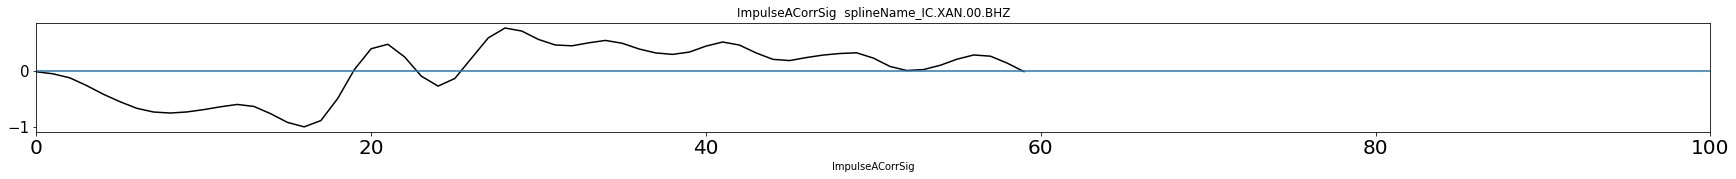

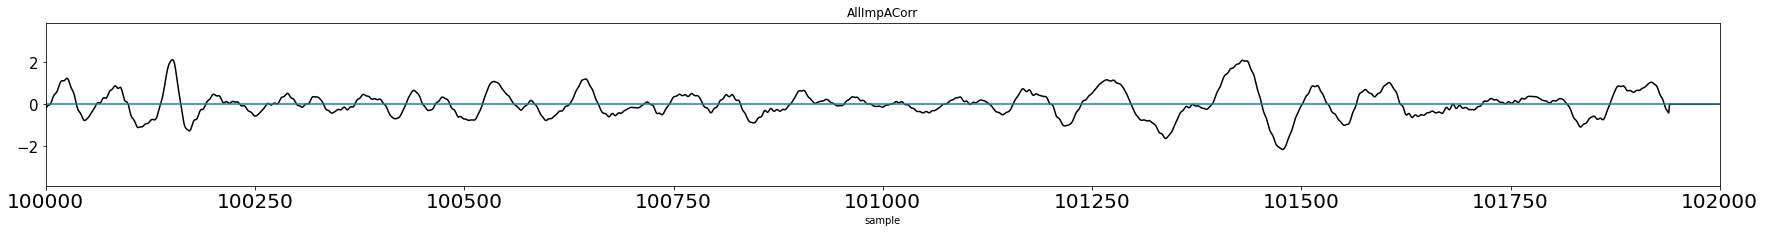

>>>>>>>>>>Onset =  96428
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.KMI.00.BHZ
b_name =  splineName_II.ARU.00.BHZ
FINAL AXcorrShiftAdded= [0.         0.         0.         ... 0.00914115 0.00314332 0.00062997] FINAL AXcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL AXcorrShiftAdded_dtype= float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
>>>>>>>>>>Onset =  96428
>>>>>>>>>>Onset =  96428
278


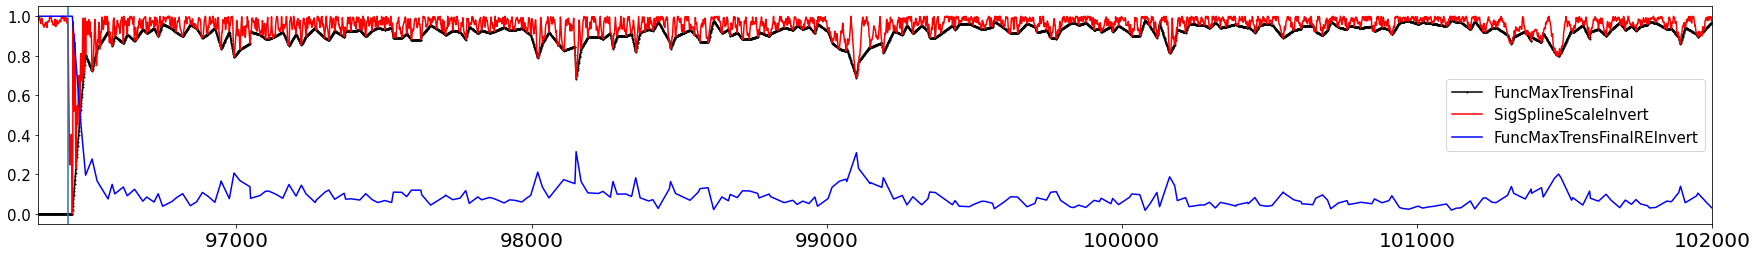

>>>>>>>>>>Onset =  96428
y = (1.14823*e ** (0.02427(x - Onset)) + 0.08300
x_line.shape =  (5571,)
y_line =  [1.23123423 1.20370028 1.17682658 ... 0.08300249 0.08300249 0.08300249]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


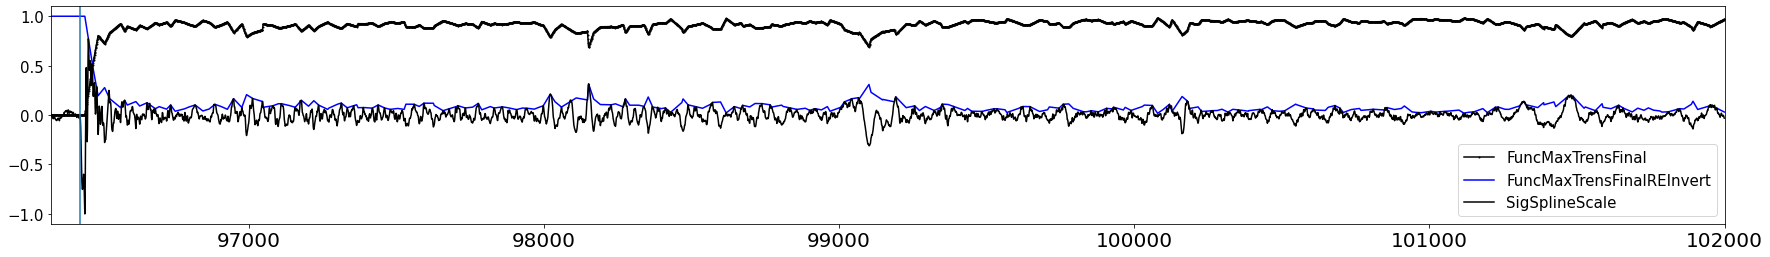

a ==  1.1482317443258772
b ==  0.02427162256698313
c ==  0.08300248701269701
GainFunction1max =  1.2312342313385742 GainFunction1min = 0.08300248701269701
GainFunction1max =  1.0 GainFunction1min = 0.06741405079556495


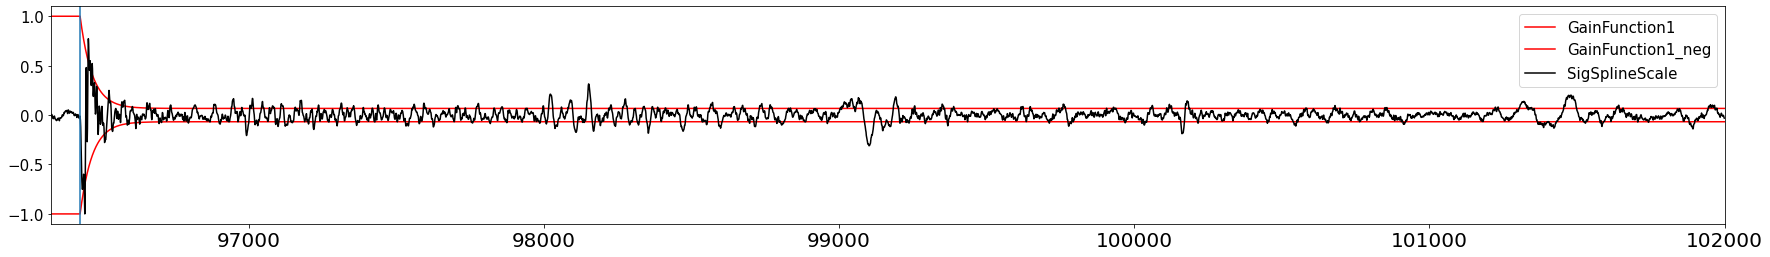

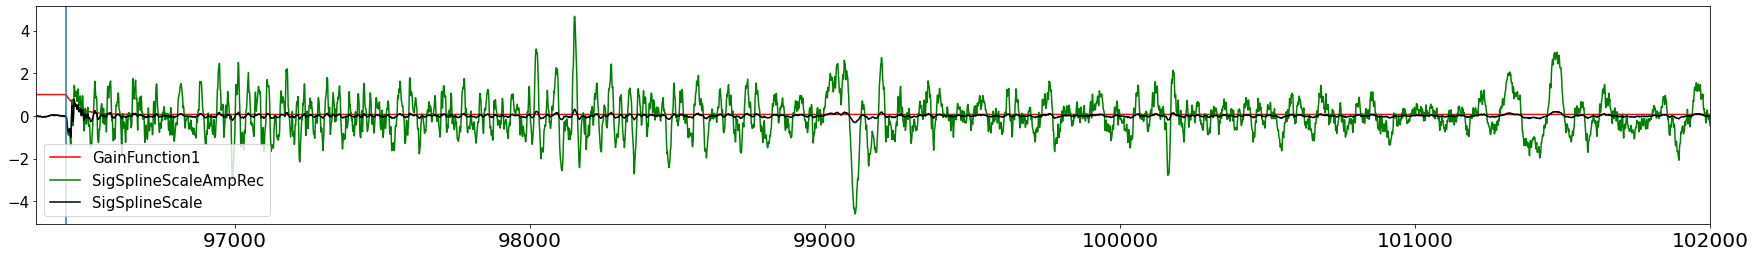

++++++++++++++++++++++++++++++++++++++++++++++++++
sig       =  [-2139 -2178 -1947 ... -2553 -2651 -2651]
deltaTime =  0.05
a1 (starttime) =  2018-09-01T14:28:24.969538Z
a2 (endtime)   =  2018-09-01T15:53:24.919538Z
npts     =  102000
SampRate =  20.0
station  =  WMQ
SigSplineScale shape =  (102000,)

 SigSplineMaxMinIndx = 98558 
 F1cfMaxMinIndx      = 98537 
 The F1cf max value precedes the Min or Max SigSpline value =  1.05 sec
The F1cf max is LESS than 30 secs ahead of the Min or Max SigSpline value  
REVIEW SIGNAL AND POSITION OF MAX F1cf TO MAIN SIGNAL 
F1cfMaxnp = 6.3541601644794605
Onset time = 98530
>>>>>>>>>>Onset =  98530
Onset  =  98530
OnsetplusT  =  98730


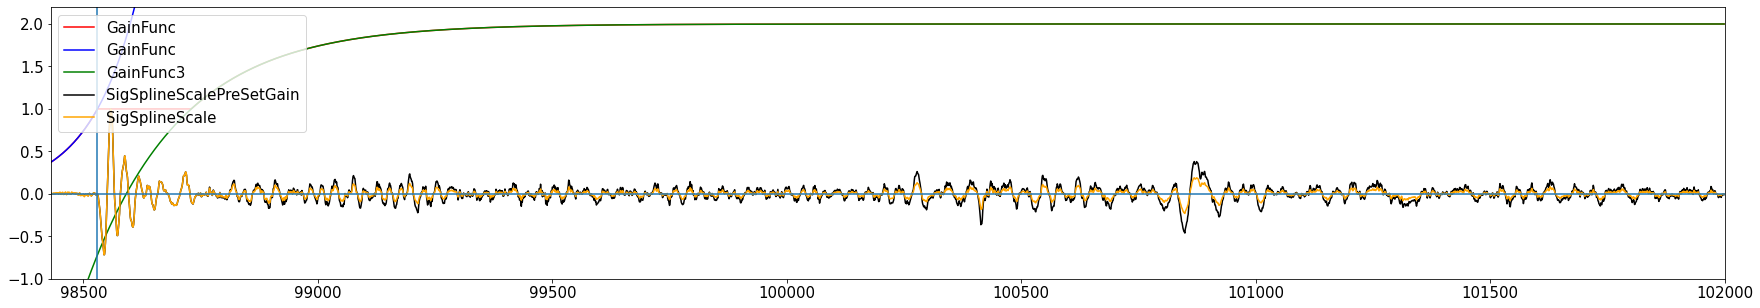

>>>>>>>>>>Onset =  98530
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
FINAL XcorrShiftAdded= [0. 0. 0. ... 0. 0. 0.] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_II.AAK.00.BHZ
FINAL XcorrShiftAdded= [0. 0. 0. ... 0. 0. 0.] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.XAN.00.BHZ
FINAL XcorrShiftAdded= [0.         0.         0.         ... 0.00181987 0.00076241 0.00026698] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.KMI.00.BHZ
FINAL XcorrShiftAdded= [0.         0.         0.         ... 0.00185719 0.00076241 

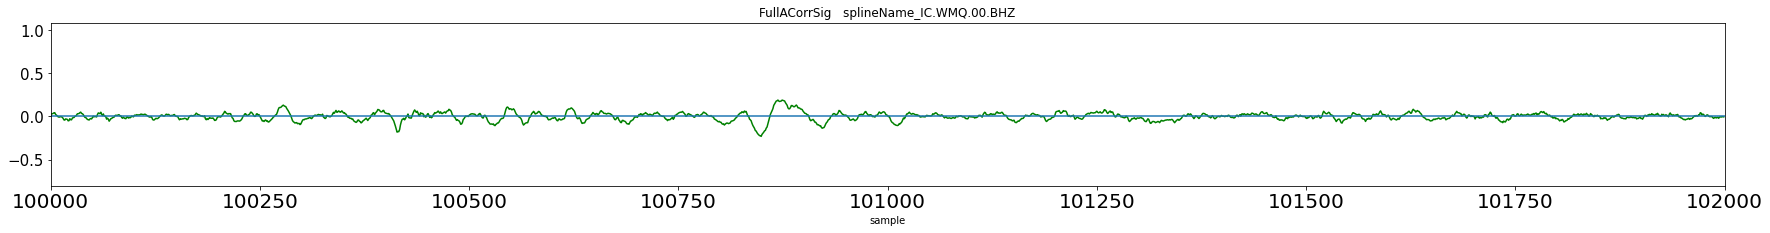

maxvalue post Impulse =  3.177910689903217


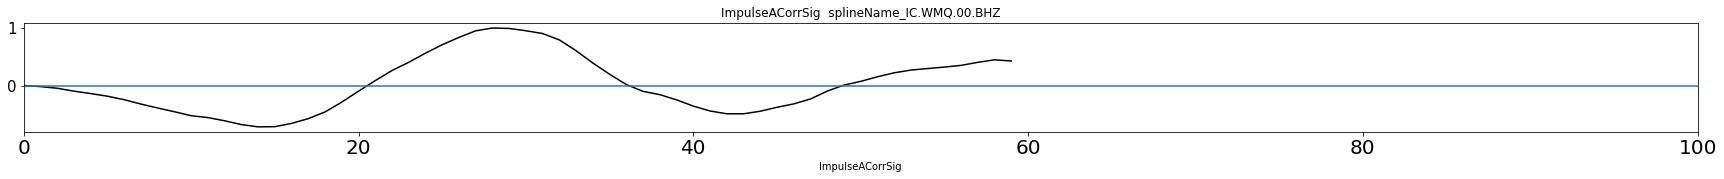

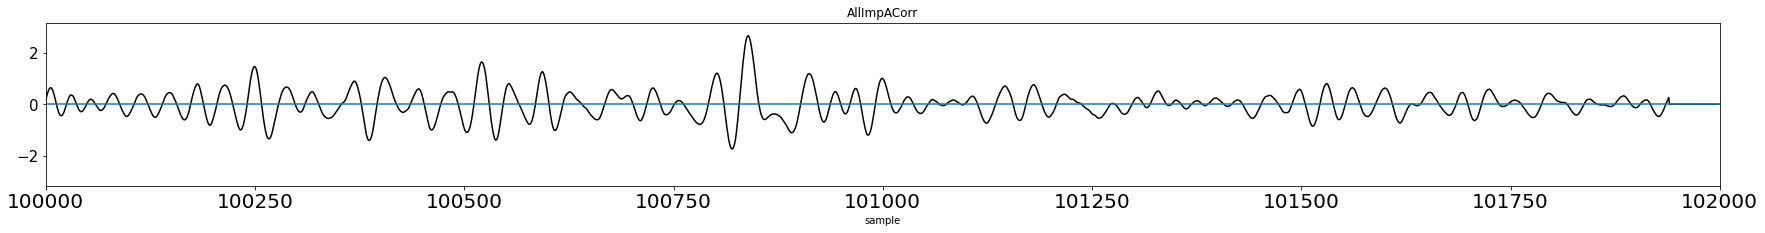

>>>>>>>>>>Onset =  98530
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.KMI.00.BHZ
b_name =  splineName_II.ARU.00.BHZ
FINAL AXcorrShiftAdded= [0.         0.         0.         ... 0.0021372  0.00083632 0.0002632 ] FINAL AXcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL AXcorrShiftAdded_dtype= float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
>>>>>>>>>>Onset =  98530
>>>>>>>>>>Onset =  98530
173


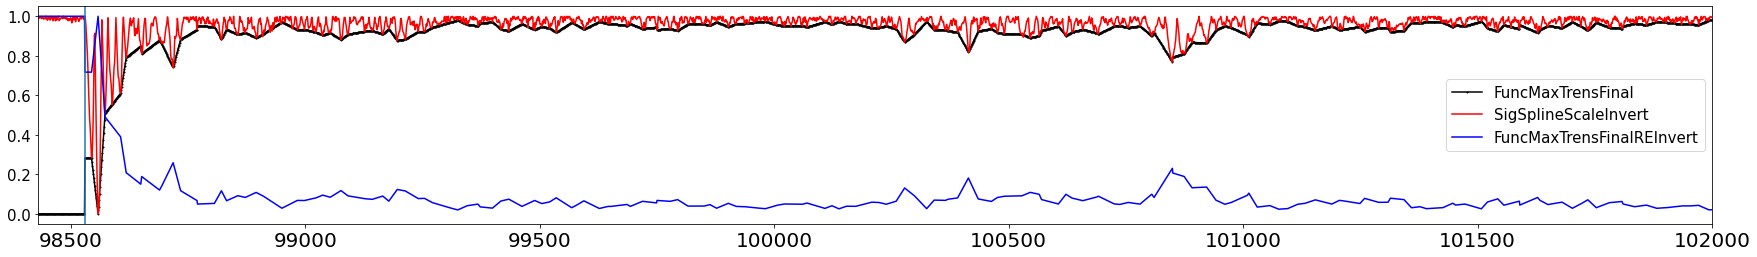

>>>>>>>>>>Onset =  98530
y = (0.88163*e ** (0.01427(x - Onset)) + 0.06244
x_line.shape =  (3469,)
y_line =  [0.94406866 0.93157667 0.91926169 ... 0.06244031 0.06244031 0.06244031]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


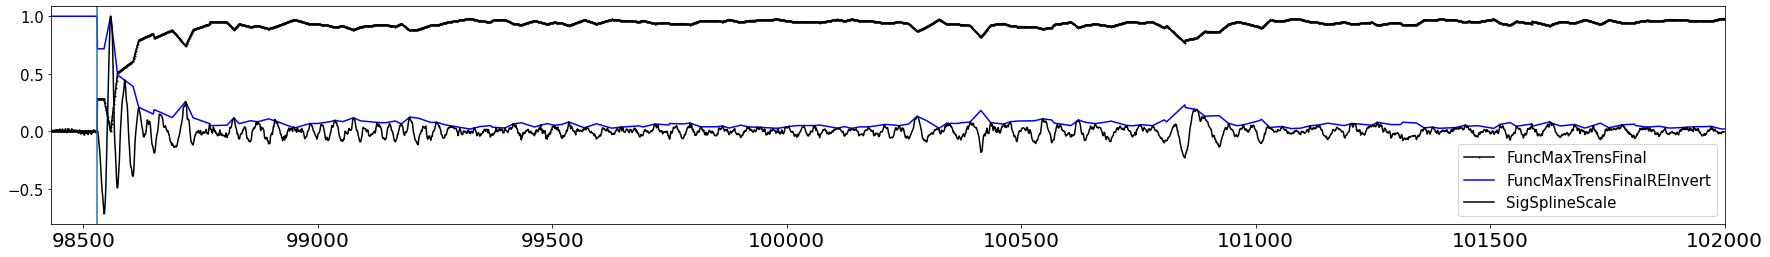

a ==  0.8816283491537662
b ==  0.01427056285039926
c ==  0.06244031053131242
GainFunction1max =  1.0 GainFunction1min = 0.06244031053131242
GainFunction1max =  1.0 GainFunction1min = 0.06244031053131242


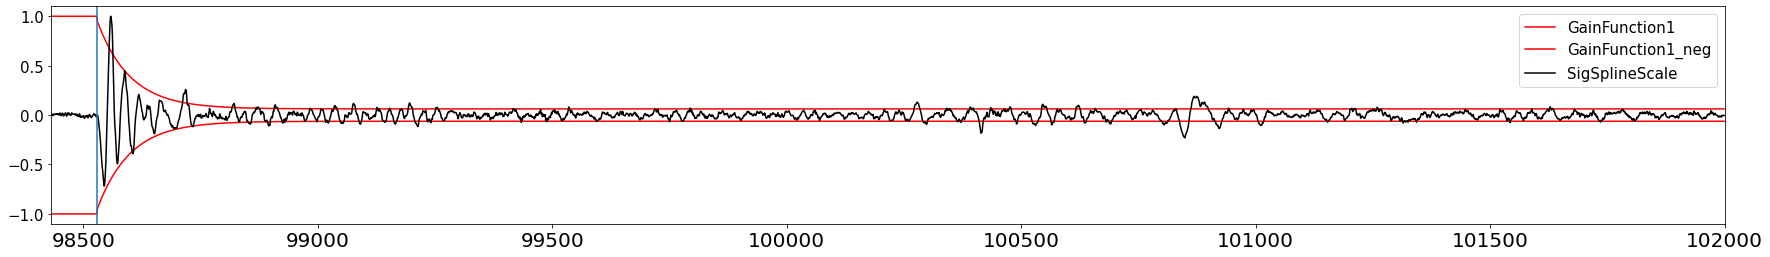

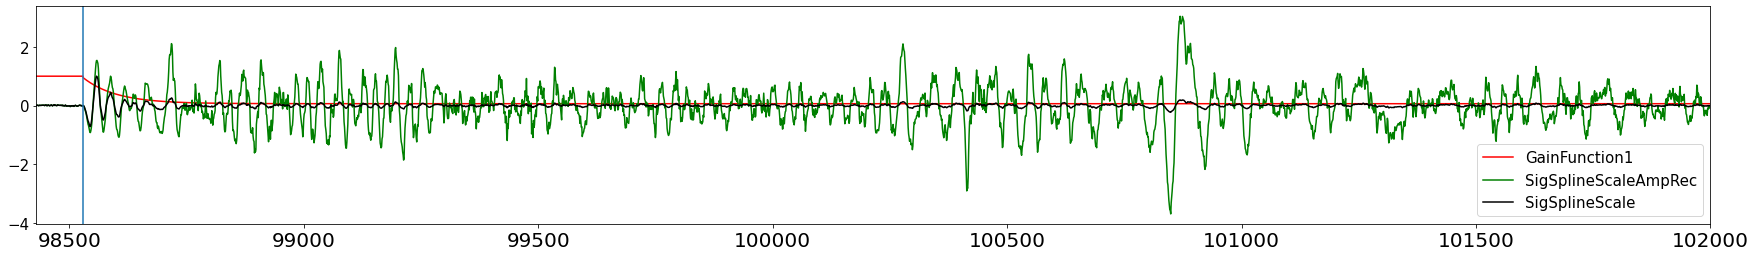

++++++++++++++++++++++++++++++++++++++++++++++++++
sig       =  [ -342  -421  -583 ... -2464 -2398 -2146]
deltaTime =  0.05
a1 (starttime) =  2018-09-01T14:28:55.719538Z
a2 (endtime)   =  2018-09-01T15:53:55.669538Z
npts     =  102000
SampRate =  20.0
station  =  KMI
SigSplineScale shape =  (102000,)

 SigSplineMaxMinIndx = 96122 
 F1cfMaxMinIndx      = 96115 
 The F1cf max value precedes the Min or Max SigSpline value =  0.35000000000000003 sec
The F1cf max is LESS than 30 secs ahead of the Min or Max SigSpline value  
REVIEW SIGNAL AND POSITION OF MAX F1cf TO MAIN SIGNAL 
F1cfMaxnp = 8.403467669749222
Onset time = 96109
>>>>>>>>>>Onset =  96109
Onset  =  96109
OnsetplusT  =  96309


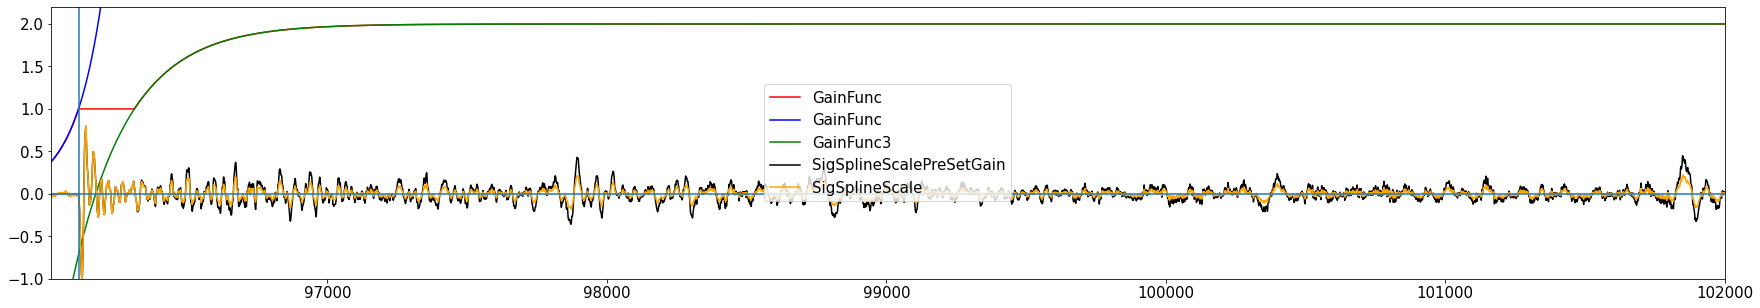

>>>>>>>>>>Onset =  96109
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_IC.KMI.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
FINAL XcorrShiftAdded= [0. 0. 0. ... 0. 0. 0.] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_II.AAK.00.BHZ
FINAL XcorrShiftAdded= [ 0.          0.          0.         ... -0.00014314 -0.00017491
  0.        ] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.XAN.00.BHZ
FINAL XcorrShiftAdded= [ 0.          0.          0.         ... -0.00146485 -0.00074091
 -0.00013925] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.WMQ.00.BHZ
FINAL XcorrShiftAdded= [ 0.          0.          0.     

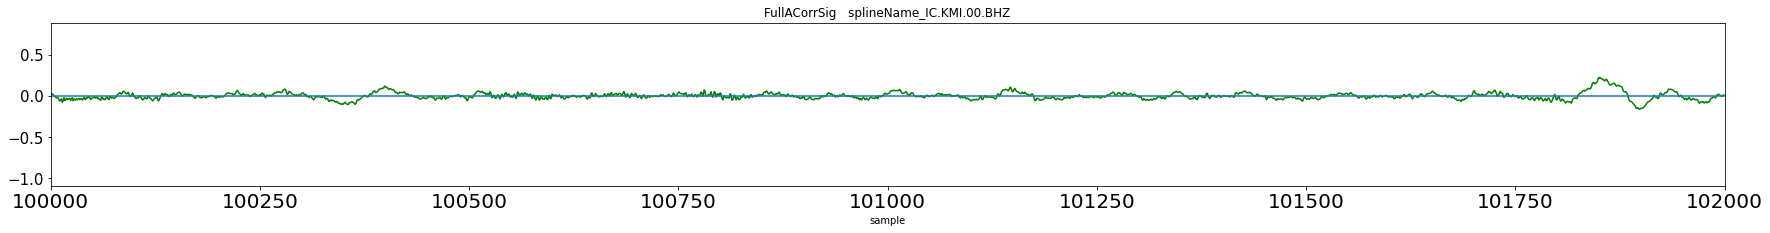

maxvalue post Impulse =  2.6557666008679117


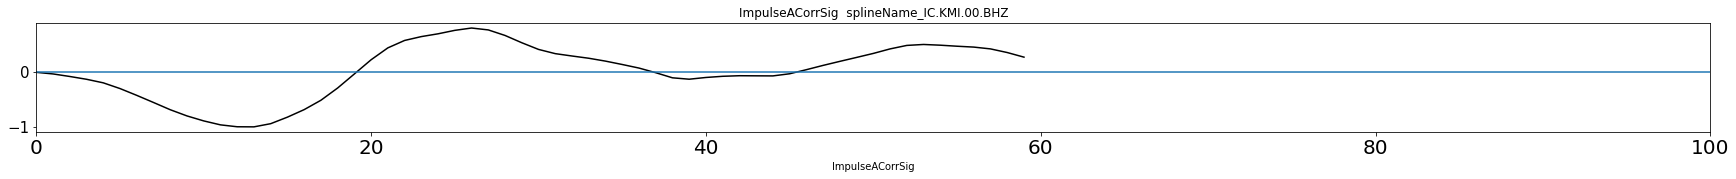

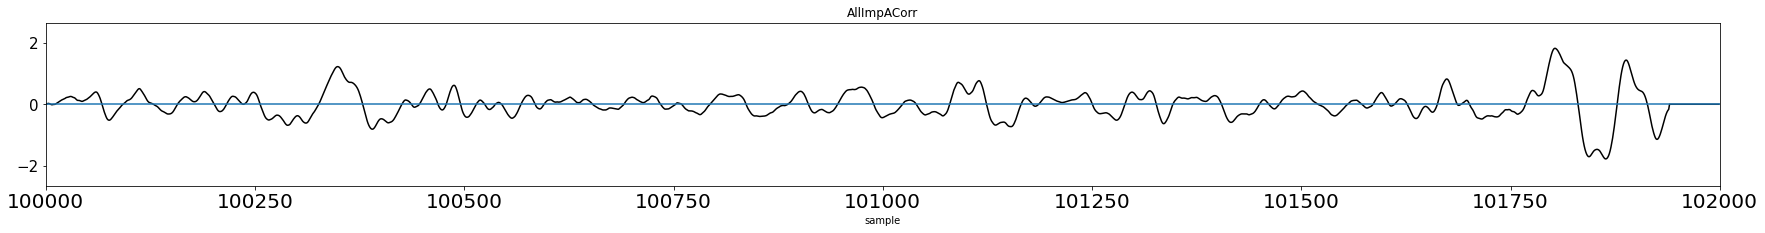

>>>>>>>>>>Onset =  96109
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_IC.KMI.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.KMI.00.BHZ
b_name =  splineName_II.ARU.00.BHZ
FINAL AXcorrShiftAdded= [ 0.          0.          0.         ... -0.00364795 -0.00219404
 -0.00077202] FINAL AXcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL AXcorrShiftAdded_dtype= float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
>>>>>>>>>>Onset =  96109
>>>>>>>>>>Onset =  96109
294


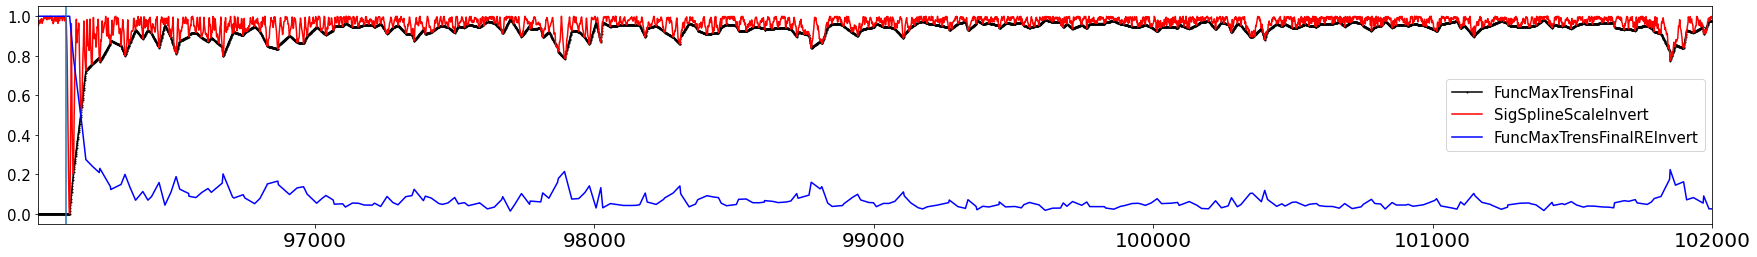

>>>>>>>>>>Onset =  96109
y = (1.06706*e ** (0.01689(x - Onset)) + 0.06552
x_line.shape =  (5890,)
y_line =  [1.13258079 1.11471277 1.09714395 ... 0.0655238  0.0655238  0.0655238 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


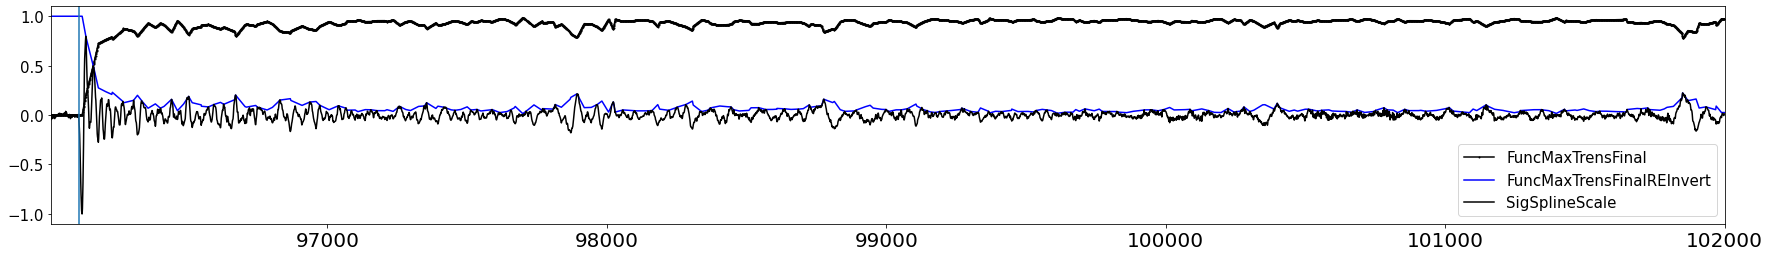

a ==  1.0670569860001695
b ==  0.01688692723728573
c ==  0.06552380418907776
GainFunction1max =  1.1325807901892473 GainFunction1min = 0.06552380418907776
GainFunction1max =  1.0 GainFunction1min = 0.057853536592413095


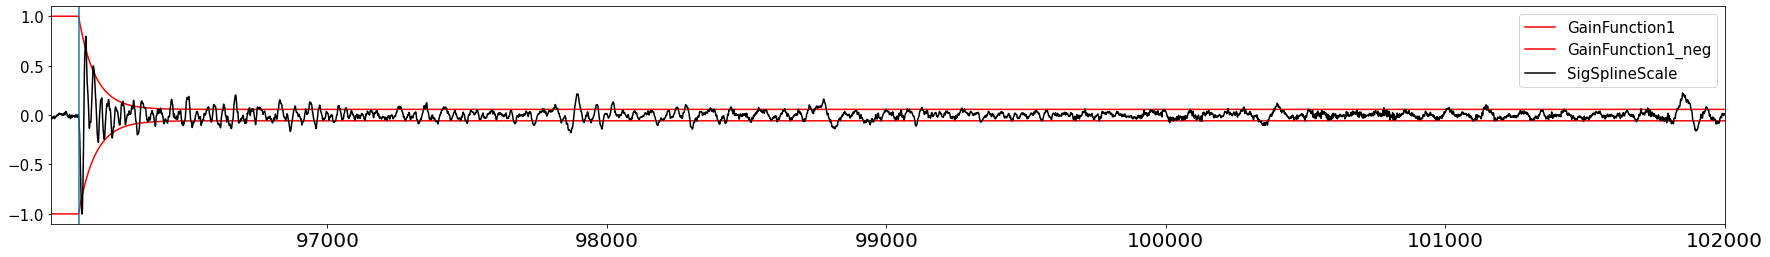

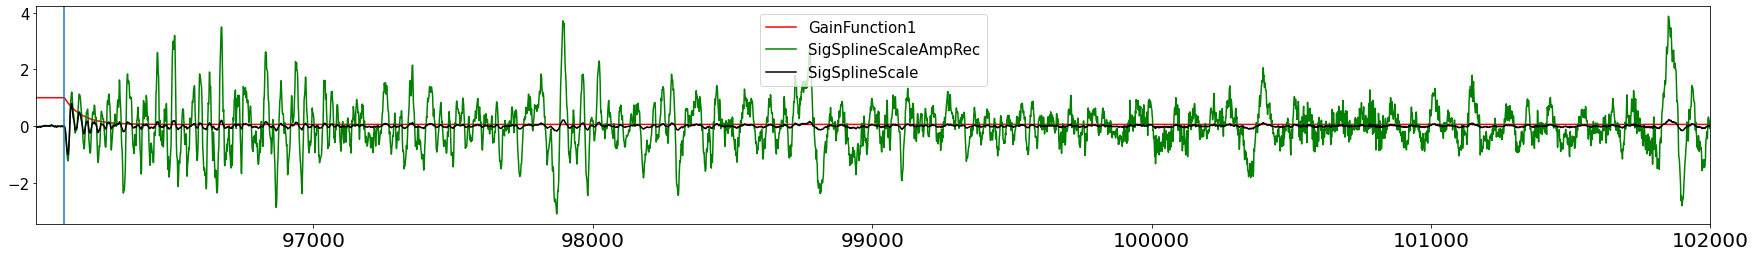

++++++++++++++++++++++++++++++++++++++++++++++++++
sig       =  [537 620 535 ... 370 351 465]
deltaTime =  0.05
a1 (starttime) =  2018-09-01T14:28:45.269538Z
a2 (endtime)   =  2018-09-01T15:53:45.219538Z
npts     =  102000
SampRate =  20.0
station  =  ARU
SigSplineScale shape =  (102000,)

 SigSplineMaxMinIndx = 100689 
 F1cfMaxMinIndx      = 100686 
 The F1cf max value precedes the Min or Max SigSpline value =  0.15000000000000002 sec
The F1cf max is LESS than 30 secs ahead of the Min or Max SigSpline value  
REVIEW SIGNAL AND POSITION OF MAX F1cf TO MAIN SIGNAL 
F1cfMaxnp = 12.292022761273172
Onset time = 100682
>>>>>>>>>>Onset =  100682
Onset  =  100682
OnsetplusT  =  100882


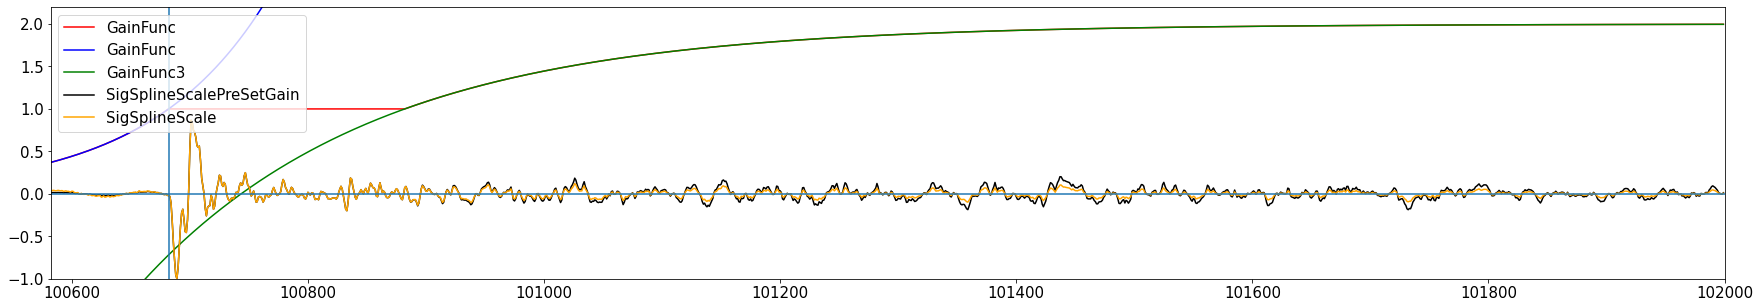

>>>>>>>>>>Onset =  100682
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_II.ARU.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
FINAL XcorrShiftAdded= [ 0.          0.          0.         ... -0.00099934 -0.0003261
 -0.00017365] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_II.AAK.00.BHZ
FINAL XcorrShiftAdded= [ 0.          0.          0.         ... -0.00299215 -0.00124631
 -0.00060376] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.XAN.00.BHZ
FINAL XcorrShiftAdded= [ 0.          0.          0.         ... -0.07680475 -0.05145676
 -0.03236567] FINAL XcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL XcorrShiftAdded_dtype= float64
b_name =  splineName_IC.WMQ.00.BHZ
F

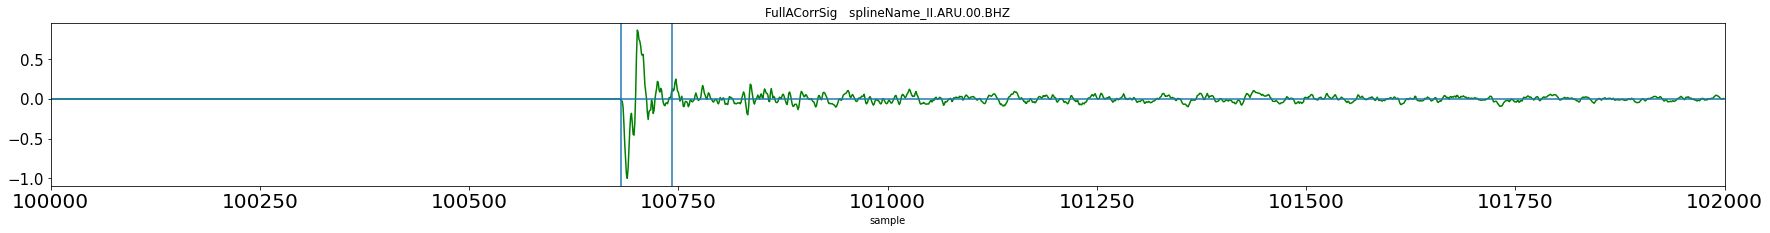

maxvalue post Impulse =  0.946116389416635


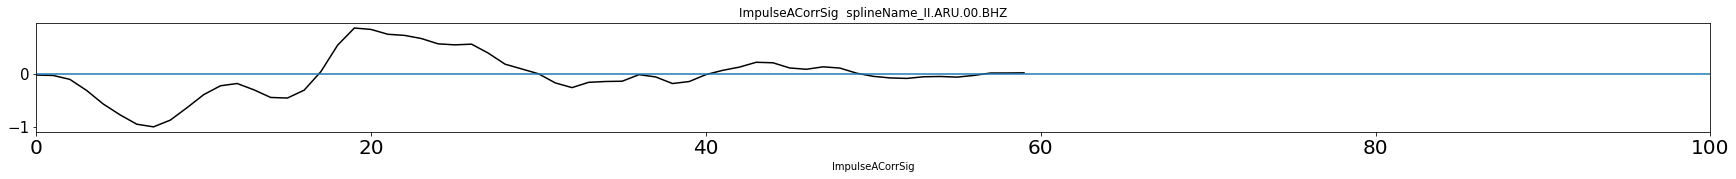

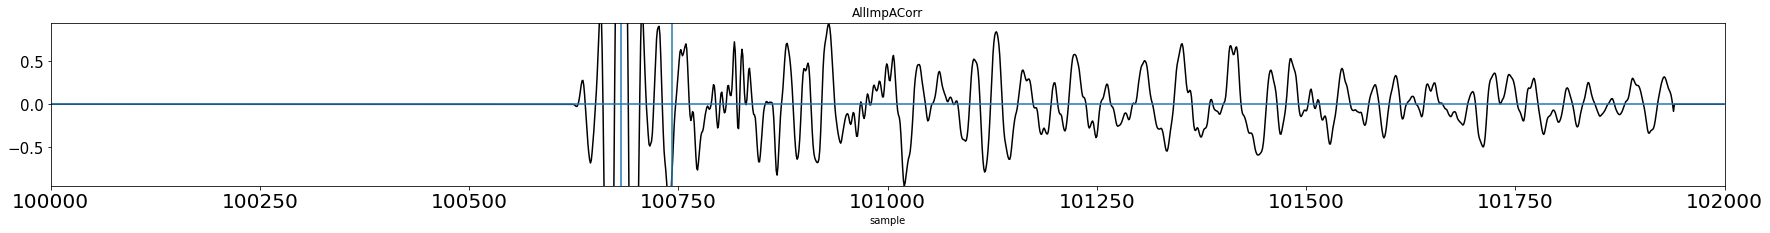

>>>>>>>>>>Onset =  100682
names =  ['splineName_IC.HIA.00.BHZ', 'splineName_II.AAK.00.BHZ', 'splineName_IC.XAN.00.BHZ', 'splineName_IC.WMQ.00.BHZ', 'splineName_IC.KMI.00.BHZ', 'splineName_II.ARU.00.BHZ']
names_sub =  ['HIA' 'AAK' 'XAN' 'WMQ' 'KMI' 'ARU']
a_name =  splineName_II.ARU.00.BHZ
b_name =  splineName_IC.HIA.00.BHZ
b_name =  splineName_II.AAK.00.BHZ
b_name =  splineName_IC.XAN.00.BHZ
b_name =  splineName_IC.WMQ.00.BHZ
b_name =  splineName_IC.KMI.00.BHZ
b_name =  splineName_II.ARU.00.BHZ
FINAL AXcorrShiftAdded= [ 0.          0.          0.         ... -0.08876179 -0.05787228
 -0.03583982] FINAL AXcorrShiftAddedtype= <class 'numpy.ndarray'> FINAL AXcorrShiftAdded_dtype= float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
>>>>>>>>>>Onset =  100682
>>>>>>>>>>Onset =  100682
65


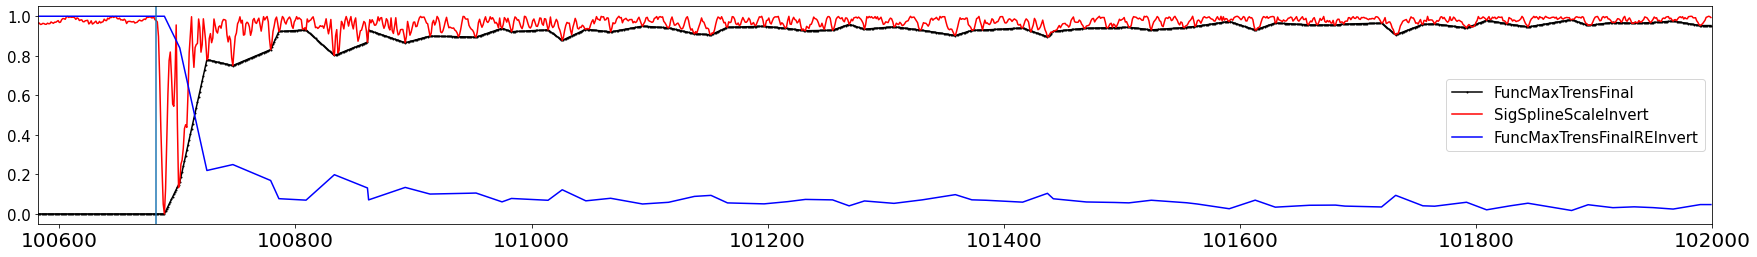

>>>>>>>>>>Onset =  100682
y = (1.11481*e ** (0.02809(x - Onset)) + 0.06348
x_line.shape =  (1317,)
y_line =  [1.17829157 1.1474166  1.11739671 ... 0.06347759 0.06347759 0.06347759]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


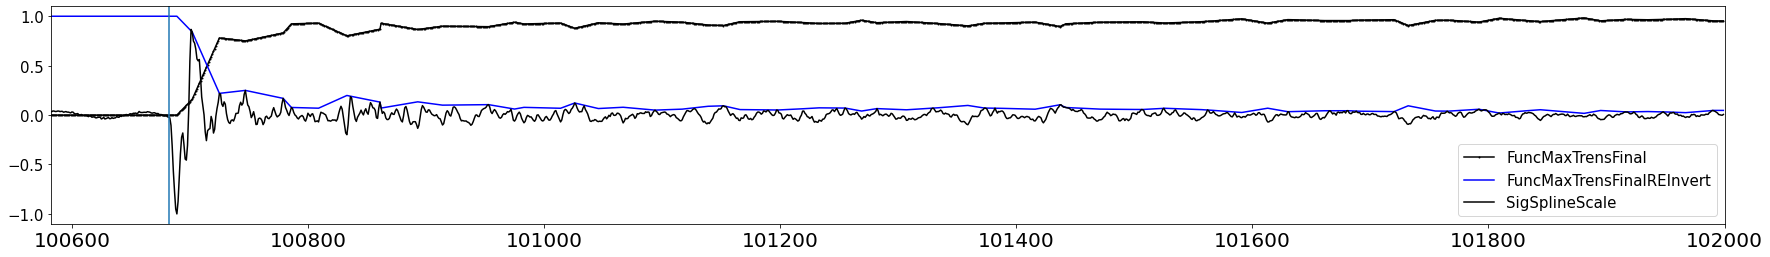

a ==  1.1148139849837
b ==  0.028085926300427545
c ==  0.06347758901410853
GainFunction1max =  1.1782915739978086 GainFunction1min = 0.06347758901410863
GainFunction1max =  1.0 GainFunction1min = 0.05387256466473441


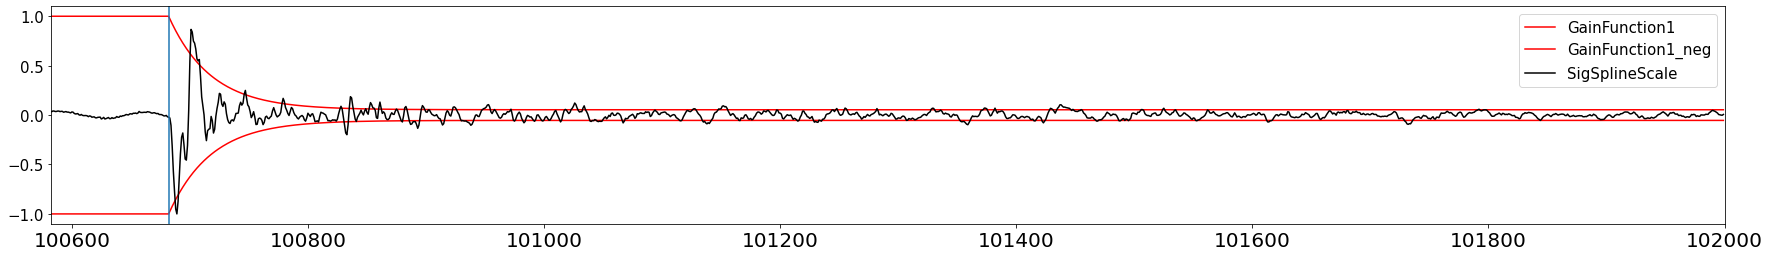

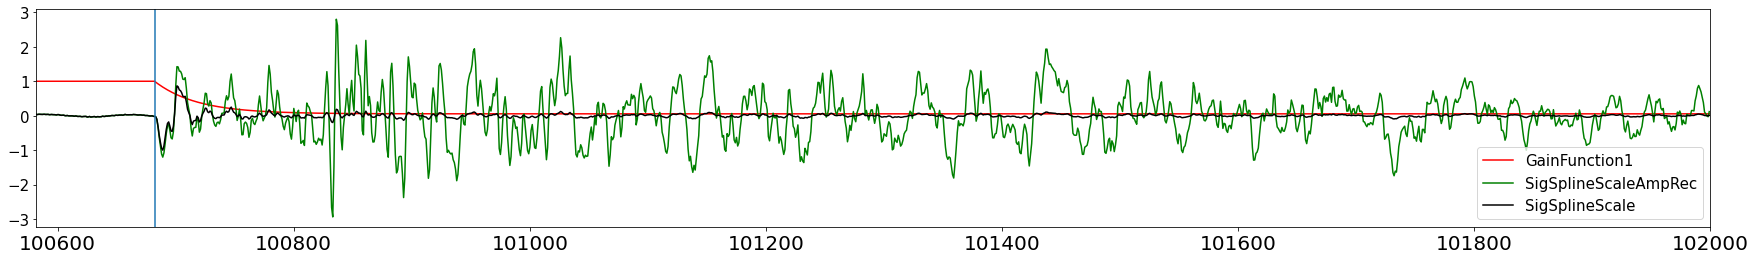

In [ ]:
def trimsiglist(siglist):
  newsiglist = []
  for i in range(len(siglist)):
    if getsampRate(siglist,i) == 20:
      newsiglist.append(siglist[i])
      print("appending", i)
    else:
      print ('XXXXXXXXX', siglist[i], "does not have a sample rate of 20")
  return newsiglist

siglist = trimsiglist(siglist)

def maxSignalnpts(siglist):
  numofSignals = len(siglist)
  print ("Number of signals  =", numofSignals)
  signalLength = []
  maxSignalLength = []
  num_attributes = []
  locnlist = []
  key = []
  val = []
  sigDict = dict()
  for i in range(len(siglist)):
    #st = []
    #npts = np.zeros(numofSignals)
    st =  obspy.read(siglist[i])[0].data
    sig = st[0].data
    npts = len(st)
    signalLength.append(npts)
    print ("\n" "npts = ", npts, "\n")

    y=siglist[i]
    nn = (y.split("/")[-1])
    locnlist.append(nn)

    filename = st
    filename = str(nn)
    value = i
    key.append(filename)
    val.append(value)
    print(key[i])
    print(value)
  maxSignalLength =  max(signalLength)
  minSignalLength =  min(signalLength)
  if maxSignalLength == minSignalLength:
    print ("\n", '+++++++++++++++++++++++++++++++++++++++++', "\n",
           "\n", '+  All inputSignalLengths are the Same  +', "\n",
           "\n", '+++++++++++++++++++++++++++++++++++++++++', "\n")
  else:
    print ("\n", '++++++++++++++++++++++++++++++++++++++++++++++++++++++++', "\n",
           "\n", '+  WARNING - The input SignalLengths are NOT the same  +', "\n",
           "\n", '++++++++++++++++++++++++++++++++++++++++++++++++++++++++', "\n")
  sigDict = dict(zip(key, val))
  ## *******************************************************************************##
  ##      Hard wire the number of attributes (num_attributes) to be created here    ##
  ## *******************************************************************************##
  #num_attributes = 20 + numofSignals
  num_attributes = 11
  return numofSignals, npts, signalLength, key, val, maxSignalLength, sigDict, num_attributes

#numofSignals, npts, signalLength, key, val, maxSignalLength, sigDict, num_attributes = maxSignalnpts(siglist)
#arr3D = np.zeros((maxSignalLength, num_attributes, numofSignals))

def generateAttrib(siglist, maxSignalLength, i):
  print("++++++++++++++++++++++++++++++++++++++++++++++++++")
  layer2D = np.zeros(( num_attributes, maxSignalLength))  # layer2d = (rows, columns)

  sig, deltaTime, a1, a2, npts, SampRate, station = signalInfo(siglist,i)
  utc, sigDF = UTC(a1, npts, deltaTime)
  #layer2D[0,:]  = utc

  relTime, Sample, sigDF = RelTime(npts, SampRate, sig, sigDF)
  # layer2D [X,Y] x = value and Y = sample or time value
  #layer2D[1,:]  = relTime
  #layer2D[2,:]  = Sample
  #layer2D[3,:]  = sig

  SigSpline, SigSplineScale = SplineScale(npts, sig, sigDF)
  #layer2D[4,:]  = SigSpline
  layer2D[0,:]   = SigSplineScale 	    # Keep  # Normalised

  #F1cf, F2cf, F3cf, F4cf, F4cfgrad, F4cfgradmeanx2, F4cfgrad_gtmean, absValues, env_pos = F1234cf_F4cfgradmeanx2_F4cfgrad_gtmean_absValues_TotalSkew_InstSkw_skw_diff(sigDF, npts, SigSplineScale)
  F1cf, F2cf, F3cf, F4cf, F4cfgrad, F4cfgradmeanx2, F4cfgrad_gtmean, absValues, env_pos, F1cf_Norm, F2cf_Norm, F3cf_Norm, F4cf_Norm, F4cfgrad_Norm, F4cfgrad_gtmean_Norm, absValues_Norm, env_pos_Norm = F1234cf_F4cfgradmeanx2_F4cfgrad_gtmean_absValues_TotalSkew_InstSkw_skw_diff(sigDF, npts, SigSplineScale)

  #F1cf_Norm = F1cf/(np.abs(F1cf)).max()
  #layer2D[1,:]  = F1cf_Norm        	        # Keep  # Normalised
  layer2D[1,:]   = F1cf        	        # Keep  # Normalised

  #layer2D[7,:]  = F2cf                         # Normalised
  #layer2D[8,:]  = F3cf                         # Normalised

  #F4cf_Norm = F4cf/(np.abs(F4cf)).max()
  #layer2D[1,:]  = F4cf_Norm        	        # Keep  # Normalised
  layer2D[2,:]   = F4cf          	      # Keep  # Normalised

  #F4cfgrad_Norm = F4cfgrad/(np.abs(F4cfgrad)).max()
  #layer2D[1,:]  = F4cf_Norm        	        # Keep  # Normalised
  layer2D[3,:]   = F4cfgrad         	  # Keep  # Normalised

  #F4cfgrad_gtmean_Norm = F4cfgrad_gtmean/(np.abs(F4cfgrad_gtmean)).max()
  #layer2D[1,:]   = F4cfgrad_gtmean_Norm        	        # Keep  # Normalised
  layer2D[4,:]   = F4cfgrad_gtmean	    # Keep  # Normalised

  #layer2D[12,:] = absValues                    # Normalised

  #env_pos_Norm  = env_pos/(np.abs(env_pos)).max()
  #layer2D[1,:]  = env_pos_Norm        	        # Keep  # Normalised
  layer2D[5,:] = env_pos                        # Normalised
  #layer2D[14,:] = env_neg                      # Normalised
  #layer2D[15,:] = InstSkw
  #layer2D[16,:] = skw_diff

  SigSplineMaxMinIndx, F1cfMaxMinIndx, TimeF1cf_ahead = MaxF1position(sigDF, deltaTime)

  F1cf_late_max_np, F1cf_late_max_idx_np, F4cf_late_max_np, F4cf_late_max_idx_np = F1cfLatePeak(F1cf, F4cf, SigSplineMaxMinIndx)

  F1cfMaxIndxnp,  F1cfOnsetVal, F1cfOnsetIdx, F1cfOnsetDF, F1cfOnset_np, Onset = sigOnset(F4cfgradmeanx2, F4cfgrad_gtmean, TimeF1cf_ahead, F1cf_late_max_np, F1cf_late_max_idx_np, F1cf, F4cf, AllOnsets,i)

  #resetTime, sigDF['resetTime'] = ResetTime(relTime, Onset, deltaTime, sigDF)
  #layer2D[17, :] = resetTime

  #sigSplnScalzero, absValueszero,  sigDF["SigSplnScalzeroed"], sigDF["absValueszero"] = SigSplnScalZero(npts, Onset, SigSplineScale, absValues, sigDF)

  #layer2D[18, :] = sigSplnScalzero
  #layer2D[19, :] = absValueszero

  SigSplineScalePreSetGain = PreSetGainFunc(Onset, SigSplineScale)
  #SigSplineScalePreSetGain_Norm = SigSplineScalePreSetGain/(np.abs(SigSplineScalePreSetGain)).max()
  #layer2D[6,:] = SigSplineScalePreSetGain_Norm
  layer2D[6,:] = SigSplineScalePreSetGain

  XcorrShiftAdded, XcorrShiftAddedabs =  Xcorrs(splinelist, names, Onset)
  #XcorrShiftAdded_Norm = XcorrShiftAdded/(np.abs(XcorrShiftAdded)).max()
  #layer2D[7,:] = XcorrShiftAdded_Norm
  layer2D[7,:] = XcorrShiftAdded

  AllImpACorr = ImpulseACorrs(splinelist, names, Onset)
  #AllImpACorr_Norm = AllImpACorr/(np.abs(AllImpACorr)).max()
  #layer2D[8,:] = AllImpACorr_Norm
  layer2D[8,:] = AllImpACorr

  AXcorrShiftAdded, AXcorrShiftAddedabs =  AXcorrs(splinelist, names, Onset)
  #AXcorrShiftAdded_Norm = AXcorrShiftAdded/(np.abs(AXcorrShiftAdded)).max()
  #layer2D[9,:] = AXcorrShiftAdded_Norm
  layer2D[9,:] = AXcorrShiftAdded

  SigSplineScaleInvert = SplineScale_Invert(npts, SigSplineScale, Onset)

  FuncMaxTrensFinal, FuncMaxTrensFinalREInvert = SignalTrendData(SigSplineScaleInvert, Onset)

  a,b,c =   GainFunction(Sample, FuncMaxTrensFinalREInvert, Onset, FuncMaxTrensFinal, SigSplineScale)
  GainFunction1, SigSplineScaleAmpRec = GainFunctionArray(a, b, c, Sample, Onset, SigSplineScale, SigSplineScaleInvert)

  #SigSplineScaleAmpRec_Norm = SigSplineScaleAmpRec/(np.abs(SigSplineScaleAmpRec)).max()
  #layer2D[10,:] = SigSplineScaleAmpRec/(np.abs(SigSplineScaleAmpRec)).max()
  #layer2D[10,:] = SigSplineScaleAmpRec_Norm
  layer2D[10,:] = SigSplineScaleAmpRec

  return layer2D

#layer2D = generateAttrib(siglist, maxSignalLength)

numofSignals, npts, signalLength, key, val, maxSignalLength, sigDict, num_attributes = maxSignalnpts(siglist)

arr3D = np.zeros((numofSignals, num_attributes, maxSignalLength))

featuresDict = {"SigSplineScale":0,	          # Keep
                "F1cf":1,	                    # Keep
                "F4cf":2,	                    # Keep
                "F4cfgrad":3,         	      # Keep
                "F4cfgrad_gtmean":4,	        # Keep
                "env_pos":5,                  # Keep
                "SigSplineScalePreSetGain":6, # Keep
                "XcorrShiftAdded":7,          # Keep
                "AllImpXcorrAdded":8,         # Keep
                "AXcorrShiftAdded":9,         # Keep
                "SigSplineScaleAmpRec":10     # Keep
               }

# what we need initially:-- (sample), SigSplineScale, F1cf, F4cf, F4cfgrad, F4cfgrad_gtmean  + Results (pP, sP  core phase prob(eg PcP), pwP))

for i in range(len(siglist)):
  # arr3D[signal : attribute : sample along trace]
  arr3D[i, : ,:] = generateAttrib(siglist, maxSignalLength, i)


In [ ]:
arr3D.shape
#arr3D[4, 7 ,:]
#arr3D[4, featuresDict['env20'] ,:]
print(AllOnsets)

[ 98700.  98983.  96428.  98530.  96109. 100682.]


In [ ]:
print(len(arr3D[4, 5 ,:]))

In [ ]:
print (AllOnsets)
print (names)

# **SECOND Auto and XCorrelations  Based on the signal 'Impulse'**

## The following cell applies a Xcorr based on the impulse signal
##Impulse Signal is 3 seconds long
## Applied from  along the signal from the relevant Onset values

In [1]:
print (names)
print (AllOnsets)

NameError: ignored

In [ ]:
SigName_Onsets = np.column_stack((names, AllOnsets) )

print (SigName_Onsets)
print("XXXXXXXXXXX")
print(SigName_Onsets[5,1])

In [ ]:
"""
def ImpulseXcorrs(splinelist, names, Onset):
  AllImpXcorrSet = []
  AllImpXcorrAdded =      []
  AllImpXcorrAddedabs =   []
  ImpXcorNames = []
  AllImpXcorr = np.zeros(len(splinelist[i]))
  AllImpXcorrAdded = np.zeros(shape=(len(splinelist[i])))
  AllImpXcorrAddedabs = np.zeros(shape=(len(splinelist[i])))

  names_sub = np.array([x.split('.')[1] for x in names])
  a_name = names[i]

  Onset_A = int(SigName_Onsets[i,1])
  FullSig = splinelist[i]
  FullSig[0 : Onset_A] = 0

  plt.figure(figsize=(30,2))
  plt.plot(FullSig,  label='FullSig ', color= 'green')
  plt.xlabel('sample')
  #plt.ylim (-1,1)
  plt.xlim(95000,102000)
  plt.axvline(Onset_A)
  plt.axvline(Onset_A+60)
  plt.axhline(0)
  plt.title('AllImpXcorrAdded')
  plt.show()

  for k in range (0, len(names)):
    b = splinelist[k]
    b_name = names[k]

    Onset_B = int(SigName_Onsets[k,1])
    ImpulseSig = splinelist[k][Onset_B:Onset_B+60]
    print("a_name = ", a_name,       "     and     b_name = ", b_name)
    print("XXXXXXXXXXXXXXX")
    if a_name == b_name:
      continue
    else:
      for j in range (0, (len(FullSig)-60) ):
        ImpXcorr = np.correlate(FullSig[j:j+60], ImpulseSig, mode='valid')    # was 'valid'  butsince lookiag ta whole signal no longer applicable
        #print(ImpXcorr)
        AllImpXcorr[j] = ImpXcorr

      filename = a_name
      filename = a_name  + '_Xcor_' + b_name
      ImpXcorNames.append(filename)

      AllImpXcorrAdded = AllImpXcorrAdded + AllImpXcorr

      AllImpXcorr_abs   = abs(AllImpXcorr)
      AllImpXcorrAddedabs = AllImpXcorrAddedabs + AllImpXcorr_abs

      plt.figure(figsize=(30,2))
      plt.plot(AllImpXcorr,  label='AllImpXcorr ', color= 'black')
      plt.xlabel('sample')
      #plt.ylim (-1,1)
      plt.xlim(95000,102000)
      plt.axvline(Onset_A)
      plt.axvline(Onset_A+60)
      plt.axhline(0)
      plt.title('AllImpXcorrAdded')
      plt.show()

      plt.figure(figsize=(30,2))
      plt.plot(AllImpXcorrAdded,  label='AllImpXcorrAdded ', color= 'red')
      plt.xlabel('sample')
      #plt.ylim (-1,1)
      plt.xlim(95000,102000)
      plt.axvline(Onset_A)
      plt.axvline(Onset_A+60)
      plt.axhline(0)
      plt.title('AllImpXcorrAdded')
      plt.show()

      if len(AllImpXcorrSet) == 0:
        AllImpXcorrSet = AllImpXcorr
      else:
        AllImpXcorrSet = np.vstack((AllImpXcorrSet, AllImpXcorr))  # why didn't np.append((XcorrSet, Xcorr)) not work ??

  plt.figure(figsize=(30,2))
  plt.plot(FullSig,  label='FullSig ', color= 'green')
  plt.xlabel('sample')
  #plt.ylim (-1,1)
  plt.xlim(95000,102000)
  plt.axvline(Onset_A)
  plt.axvline(Onset_A+60)
  plt.axhline(0)
  plt.title('AllImpXcorrAdded')
  plt.show()

  return AllImpXcorrAdded, AllImpXcorrAddedabs

AllImpXcorrAdded, AllImpXcorrAddedabs =  ImpulseXcorrs(splinelist, names, Onset)
"""

### **Code in cell below is basically same as code in cell above but modified to run in a full routine and accesses results from AllOnsets and running arr3D **

In [ ]:
print(SigName_Onsets)
print(SigName_Onsets[5,1])

In [ ]:
def ImpulseXcorrs(arr3D, splinelist, names, AllOnsets):
  AllImpXcorrSet = []
  AllImpXcorrAdded =      []
  AllImpXcorrAddedabs =   []
  ImpXcorNames = []
  AllImpXcorr = np.zeros(len(splinelist[i]))
  AllImpXcorrAdded = np.zeros(shape=(len(splinelist[i])))
  AllImpXcorrAddedabs = np.zeros(shape=(len(splinelist[i])))

  names_sub = np.array([x.split('.')[1] for x in names])
  a_name = names[1]     #i

  Onset_A = (SigName_Onsets[i,1])
  Onset_A = int(float(Onset_A))
  FullSig = arr3D[i, 0,:]
  FullSig[0 : Onset_A] = 0

  plt.figure(figsize=(30,2))
  plt.plot(FullSig,  label='FullSig ', color= 'green')
  plt.xlabel('sample')
  #plt.ylim (-1,1)
  plt.xlim(95000,102000)
  plt.axvline(Onset_A)
  plt.axvline(Onset_A+60)
  plt.axhline(0)
  plt.title('FullSig   ' +str(a_name))
  plt.show()

  for k in range (0, len(names)):
    b = splinelist[k]
    b_name = names[k]

    Onset_B = (SigName_Onsets[k,1])
    Onset_B = int(float(Onset_B))
    ImpulseSig = arr3D[k, 0, :][Onset_B:Onset_B+60]     # was splinelist[k][Onset_B:Onset_B+60]
    print("a_name = ", a_name,       "     and     b_name = ", b_name)
    print("XXXXXXXXXXXXXXX")
    if i == k:  # this now simply compares the SigSplineScale SIGNALS saved within the arr3D array and if they are the same do NOT RUN XCORR
      continue
    else:
      for j in range (0, (len(FullSig)-60) ):
        ImpXcorr = np.correlate(FullSig[j:j+60], ImpulseSig, mode='valid')    # was 'valid'  butsince looking ta whole signal no longer applicable
        #print(ImpXcorr)
        AllImpXcorr[j] = ImpXcorr

      filename = a_name
      filename = a_name  + '_Xcor_' + b_name
      ImpXcorNames.append(filename)

      AllImpXcorrAdded = AllImpXcorrAdded + AllImpXcorr

      AllImpXcorr_abs   = abs(AllImpXcorr)
      AllImpXcorrAddedabs = AllImpXcorrAddedabs + AllImpXcorr_abs

      plt.figure(figsize=(30,2))
      plt.plot(ImpulseSig,  label='ImpulseSig ', color= 'black')
      plt.xlabel('ImpulseSig')
      #plt.ylim (-1,1)
      plt.xlim(0,100)
      plt.axvline(Onset_A)
      plt.axvline(Onset_A+60)
      plt.axhline(0)
      plt.title('ImpulseSig  '  +str(b_name))
      plt.show()

      plt.figure(figsize=(30,2))
      plt.plot(AllImpXcorr,  label='AllImpXcorr ', color= 'black')
      plt.xlabel('sample')
      #plt.ylim (-1,1)
      plt.xlim(95000,102000)
      plt.axvline(Onset_A)
      plt.axvline(Onset_A+60)
      plt.axhline(0)
      plt.title('AllImpXcorr')
      plt.show()

      plt.figure(figsize=(30,2))
      plt.plot(AllImpXcorrAdded,  label='AllImpXcorrAdded ', color= 'red')
      plt.xlabel('sample')
      #plt.ylim (-1,1)
      plt.xlim(95000,102000)
      plt.axvline(Onset_A)
      plt.axvline(Onset_A+60)
      plt.axhline(0)
      plt.title('AllImpXcorrAdded')
      plt.show()

      if len(AllImpXcorrSet) == 0:
        AllImpXcorrSet = AllImpXcorr
      else:
        AllImpXcorrSet = np.vstack((AllImpXcorrSet, AllImpXcorr))  # why didn't np.append((XcorrSet, Xcorr)) not work ??

  return AllImpXcorrAdded   #, AllImpXcorrAddedabs

AllImpXcorrAdded =  ImpulseXcorrs(arr3D, splinelist, names, AllOnsets)

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(AllImpXcorrAdded,  label='AllImpXcorrAdded ', color= 'green')
plt.plot(arr3D[5, 7 ,:],  label='arr3D ', color= 'blue')
plt.plot(arr3D[5, 0 ,:],  label='SigSplinescale ', color= 'black')
plt.xlabel('sample')
plt.legend()
#plt.ylim (-1,1)
plt.xlim(98500,102000)
#plt.axvline(Onset_A)
#plt.axvline(Onset_A+60)
plt.axhline(0)
plt.title('AllImpXcorrAdded')
plt.show()

plt.figure(figsize=(30,5))
plt.plot(arr3D[5, 0 ,:],  label='SigSplinescale ', color= 'black')
plt.xlabel('sample')
plt.legend()
#plt.ylim (-1,1)
plt.xlim(98500,102000)
#plt.axvline(Onset_A)
#plt.axvline(Onset_A+60)
plt.axhline(0)
plt.title('AllImpXcorrAdded')
plt.show()


plt.figure(figsize=(30,5))
plt.plot(AllImpXcorrAdded,  label='AllImpXcorrAdded ', color= 'green')
plt.plot(((arr3D[5, 8 ,:])*6),  label='ImpACorr ', color= 'red')
plt.xlabel('sample')
plt.legend()
#plt.ylim (-1,1)
plt.xlim(98800,100000)
#plt.axvline(Onset_A)
#plt.axvline(Onset_A+60)
plt.axhline(0)
plt.title('AllImpXcorrAdded')
plt.show()

## Code below is for Xcorrs using the Impulse signal from the second signal for the Xcorr. Having run code above we now have all the Onsets in 'AllOnsets' and all the SigSpline Scales in 'arr3D'

In [ ]:
print ('arr3D.shape = ', arr3D.shape)

# **SECOND Batch Run**

The following code runs a batch of signals Please note:

1.   Here we make use of all the Onsets created in the First Batch run
2.   We run the Xcorrs using the 'impulse of a signal' as one of the signals and Xcorrelate with the second signal
3.   As with the first batch we hardwire in the number of attributes (Add_attributes) to be generated

cf First Second batch run above

In [ ]:
####   This 2nd (second) batch run currently just generates the Xcorrs using the Impulse methodology
####   The number of attributes that will be created "Add_attributes" is harded wired into the function as 1  (2) at present. Should other attributes be required then this number will have to change
####
Add_attributes = 1   # 2
def AdditionalAttrib(arr3D, AllOnsets, maxSignalLength, i):
  Add_attributes = 1   # 2
  print("++++++++++++++++++++++++++++++++++++++++++++++++++")
  layer2D_additional = np.zeros(( Add_attributes, maxSignalLength))  # layer2d = (rows, columns)

  AllImpXcorrAdded =  ImpulseXcorrs(arr3D, splinelist, names, AllOnsets)
  layer2D_additional[0,:] = AllImpXcorrAdded
  #layer2D_additional[1,:] = AllImpXcorrAddedabs

  return layer2D_additional

numofSignals, npts, signalLength, key, val, maxSignalLength, sigDict, num_attributes = maxSignalnpts(siglist)

arr3D_additional = np.zeros((numofSignals, Add_attributes, maxSignalLength))

#AllImpXcorrAdded, AllImpXcorrAddedabs        = AdditionalAttrib(arr3D, AllOnsets, maxSignalLength, i)

featuresDict_additional = {"AllImpXcorrAdded"   :0,	          # Keep
                           "AllImpXcorrAddedabs":1,	          # Keep
                         }

for i in range(len(siglist)):
  # arr3D[signal : attribute : sample along trace]

  arr3D_additional[i, : ,:] = AdditionalAttrib(arr3D, AllOnsets, maxSignalLength, i)


In [ ]:
print ('arr3D_additional.shape =  ',   arr3D_additional.shape)
print ('arr3D.shape =  ',   arr3D.shape)

In [ ]:
arr3D_merge = np.concatenate((arr3D, arr3D_additional), axis = 1)
print ('arr3D_merge.shape =  ',   arr3D_merge.shape)

In [ ]:
plt.figure(figsize=(40,7))
plt.plot((arr3D_merge[2,0,:])*20,  label='SigSplineScale ', color= 'black')
plt.plot(arr3D_merge[2,7,:],  label='XcorrShiftAdded ', color= 'green')
plt.plot((arr3D_merge[2,8,:])*4,  label='AllImpACorr ', color= 'magenta')
#plt.plot(arr3D_merge[2,9,:],  label='AXcorrShiftAdded ', color= 'blue')
plt.plot(arr3D_merge[2,11,:],  label='AllImpXcorrAdded ', color= 'red')
plt.xlabel('sample')
#plt.ylim (-1,1)
plt.xlim(96000,100000)
#plt.axvline(Onset_A)
#plt.axvline(Onset_A+60)
plt.axhline(0)
plt.title('AllImpXcorrAdded')
plt.legend(fontsize=20, title_fontsize=15)
plt.show()


In [ ]:
for i in range(0,len(siglist)):
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
  for j in range(0,8):
    plt.figure(figsize=(30,2))
    #plt.ylim([-10, 10])
    #plt.xlim([98000, len(arr3D[4, 5 ,:])])
    plt.xlim([98000, 100000])
    #plt.xlim([98500, 99000])
    plt.plot(arr3D[i,j,:], label='arr3D[k]', color= 'blue')
    #plt.plot(arr3D[i,5,:], label='arr3D[k]', color= 'green')
    #plt.yticks(np.arange(-50, 120, 50))
    plt.xticks(fontsize = 15)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=15)
    plt.axhline(y=0)
    plt.axvline(x=Onset)
    plt.legend(fontsize=15)
    plt.show()

In [ ]:
print (Onset)

# **CEPSTRUM**

NB These Cepstrum attributes are not as yet included in the arrays generated above

In [ ]:
siglist = ["/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.HIA.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/II.AAK.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.XAN.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.WMQ.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/IC.KMI.00.BHZ",
        "/content/gdrive/My Drive/ISC_RAWFILES_2ndTranche/II.ARU.00.BHZ"]

siglist1 = []
locnlist = []
splinelist = []
names = []
splinesignals = {}
for i in range(len(siglist)):

  #obspy.read(siglist[i]).plot()
  resultXcor =  (spline(obspy.read(siglist[i])[0].data, order=2, dspline=1000, plot=False))

  """
  st = obspy.read(siglist[i])
  data = st[0].data
  npts = st[0].stats.npts
  samprate = st[0].stats.sampling_rate

  st_filt = st.copy
  st_filt.filter('bandpass', freqmin=1, freqmax=3, corners=2, zerophase=True)
  data_envelope = obspy.signal.filter.envelope(st_filt.data)

  """
  SplineScalerXcor = (np.abs(resultXcor)).max()
  SigSplineScaleXcor = resultXcor / SplineScalerXcor
  print("\n"  "The SplineScaler =", SplineScalerXcor, "\n")

  splinelist.append(SigSplineScaleXcor)

  y=siglist[i]
  nn = (y.split("/")[-1])
  locnlist.append(nn)
  filename = SigSplineScaleXcor
  filename = 'splineName'  + '_' + str(nn)
  names.append(filename)

  splinesignals[filename] = [SigSplineScaleXcor]

print(" the splinelist is a follows:  ", splinelist)
splinelist

In [ ]:
#framesize = npts
#print ('framesize'  , framesize)
windowed_signal = []
print ( "sig       = ", sig)
print ( "deltaTime = ", deltaTime)
print ( "npts     = ", npts)
print ( "SampRate = ", SampRate)

In [ ]:
#print ('framesize'  , framesize)
print ( "sig       = ", sig)
print ( "deltaTime = ", deltaTime)
print ( "npts     = ", npts)
print ( "SampRate = ", SampRate)

For Cepstrum:

Apply a hamming window to minimise edge effect/ non-infinite signal

Apply FFT

Derive magnitude (abs() )

Derive log scale

Apply InverseFFT

In [ ]:
for i in range (0, len(siglist)):

  if i == 0:
    StartSamp = 98700
  if i == 1:
    StartSamp = 98983
  if i == 2:
    StartSamp = 96428
  if i == 3:
    StartSamp = 98530
  if i == 4:
    StartSamp = 96109
  if i == 5:
    StartSamp = 100682

  #ShortSig = splinelist[i][96000 : len(splinelist[i])]
  ShortSig = splinelist[i][StartSamp : (StartSamp+1000)]
  print (" length of ShortSig = ", len(ShortSig) )
  ShortSig_npts = len(ShortSig)

  ShortSig_Hamm = np.hamming(ShortSig_npts) * ShortSig
  #dt = 1
  dt = 1/SampRate
  freq_vector = np.fft.rfftfreq(ShortSig_npts, d=dt)
  #X = np.fft.rfft(ShortSig_Hamm)
  X = scipy.fft.fft(ShortSig)
  #X = np.fft.fft(ShortSig)  # X = np.fft.rfft(ShortSig)         This does not apply a hamming filter so potential issues with a non-infinite signal
  log_X = np.log(np.abs(X))

  #log_X2 = np.log((X*X))
  log_Xcomplex = np.log((X))

  #cepstrum = np.fft.ifft(log_X)       #np.fft.irfft(log_X)
  cepstrum = scipy.fft.ifft(log_X)       #np.fft.irfft(log_X)
  #cepstrumcomplx = np.fft.irfft(log_Xcomplex)
  cepstrumcomplx = scipy.fft.irfft(log_Xcomplex)

  df = freq_vector[1] - freq_vector[0]
  quefrency_vector = np.fft.rfftfreq(log_X.size, df)

  cepstrum_abs = np.abs(cepstrum)
  cepstrum_flip = np.flip(cepstrum_abs)
  cepstrum_abs_mean = np.mean(cepstrum_abs)

  plt.figure(figsize=(30,3))
  plt.plot(ShortSig,  label='ShortSig ', color= 'black')
  #plt.plot(cepstrum, label='cepstrum', color= 'red')
  plt.xlabel('quefrency (s)')
  plt.axhline(0)
  plt.axvline(0)
  plt.axvline(60)
  plt.title('cepstrum')
  plt.show()

  plt.figure(figsize=(30,3))
  plt.ylim([-0.1, .1])
  #plt.xlim([0, 100])
  #plt.plot(quefrency_vector, np.abs(cepstrum), label='frequency (Hz)', color= 'blue')
  #plt.plot(quefency, np.abs(cepstrum), label='abs(cepstrum)', color= 'blue')
  #plt.plot(quefency, cepstrum, label='cepstrum', color= 'green')
  plt.plot(np.abs(cepstrum), label='cepstrum', color= 'red')
  plt.plot(cepstrumcomplx, label='cepstrumcomplx', color= 'green')
  plt.plot(np.abs(cepstrum), label='cepstrum', color= 'red')
  plt.axhline(cepstrum_abs_mean*2)
  plt.xlabel('abs(cepstrum)')
  plt.title('cepstrum')
  plt.show()


  plt.figure(figsize=(30,2))
  plt.ylim([0, .1])
  plt.xlim([0, 100])
  plt.plot(np.abs(cepstrum), label='cepstrum', color= 'red')
  plt.plot(cepstrum_flip, label='cepstrum_flip', color= 'blue')
  plt.xlabel('abs(cepstrum)')
  plt.title('cepstrum')
  plt.show()

  print (" length of ShortSig = ", len(ShortSig) )
  print (" freq_vector[0] = ", freq_vector[0], " freq_vector[100] = ", freq_vector[100] )
  print (" length of quefrency_vector = ", len(quefrency_vector) )
  print (" length of freq_vector = ", len(freq_vector) )
  print (" length of cepstrum = ", len(cepstrum) )
  print (" cepstrum  mean = ", cepstrum_abs_mean )
  print (" df = ", df )
  print (" ================================= " )




### This next cell starts to look at windowing along the trace this should allow comparison between the initial (base) CEPSTRUM  after the Onset with subsequent Cepstrums along the trace

### This work is not complete

In [ ]:
for i in range (0, len(siglist)):

  if i == 0:
    StartSamp = 98700
  if i == 1:
    StartSamp = 98983
  if i == 2:
    StartSamp = 96428
  if i == 3:
    StartSamp = 98530
  if i == 4:
    StartSamp = 96109
  if i == 5:
    StartSamp = 100682

  ImpulseSize = 60   # Window size this equates to 3 seconds with a Delta T of 0.05 seconds persample

  #for k in range (StartSamp, len(ShortSig)-ImpulseSize):
  ShortSig = splinelist[i][StartSamp : (StartSamp+ImpulseSize)]
  ShortSig_npts = len(ShortSig)

  ShortSig_Hamm = np.hamming(ImpulseSize) * ShortSig
  #dt = 1
  dt = 1/SampRate
  freq_vector_impulse = np.fft.rfftfreq(ShortSig_npts, d=dt)
  X = np.fft.rfft(ShortSig_Hamm)
  log_X = np.log(np.abs(X))

  cepstrum_impulse = np.fft.irfft(log_X)
  df = freq_vector[1] - freq_vector[0]
  quefrency_vector_impulse = np.fft.rfftfreq(log_X.size, df)

  cepstrum_abs_impulse = np.abs(cepstrum_impulse)
  cepstrum_flip_impulse = np.flip(cepstrum_abs_impulse)
  cepstrum_abs_mean_impulse = np.mean(cepstrum_abs_impulse)

  plt.figure(figsize=(30,2))
  plt.ylim([0, .5])
  plt.plot(np.abs(cepstrum_impulse), label='cepstrum_impulse', color= 'red')
  #plt.plot(cepstrum_flip_impulse, label='cepstrum_flip_impulse', color= 'blue')
  plt.xlabel('abs(cepstrum_impulse)')
  plt.title('cepstrum_impulse')
  plt.show()


"""
  print (" length of ShortSig_Hamm = ", len(ShortSig_Hamm) )
  print (" freq_vector[0] = ", freq_vector[0], " freq_vector[100] = ", freq_vector[100] )
  print (" length of quefrency_vector_impulse = ", len(quefrency_vector_impulse) )
  print (" length of freq_vector = ", len(freq_vector) )
  print (" length of cepstrum_impulse = ", len(cepstrum_impulse) )
  print (" cepstrum  mean_impulse = ", cepstrum_abs_mean_impulse )
  print (" df = ", df )
  print (" ================================= " )
"""
